<a href="https://colab.research.google.com/github/Er-PPJ/Air-Pollution-Image-Dataset-From-India-and-Nepal/blob/main/Copy_of_MV%26SR_30_Full_Stratified_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Majority voting and sum rule - ensemble learning

In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
from tensorflow.keras import backend as K

# Define custom precision, recall, and f1_score functions
def precision(y_true, y_pred):
    # Convert predictions to binary (using argmax for multi-class)
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)

    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # True Positives
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))  # False Positives

    precision = tp / (tp + fp + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Convert predictions to binary (using argmax for multi-class)
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)

    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # True Positives
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))  # False Negatives

    recall = tp / (tp + fn + K.epsilon())
    return recall
def f1_score(y_true, y_pred):
    # Calculate precision and recall
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    # Calculate F1 score
    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

In [4]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the directories in Google Drive
X, y = [], []
base_dir = '/content/drive/My Drive/APF'  # Update to match your Google Drive structure
directories = {
    'a': os.path.join(base_dir, 'a_Good'),
    'b': os.path.join(base_dir, 'b_Moderate'),
    'c': os.path.join(base_dir, 'c_Unhealthy_for_Sensitive_Groups'),
    'd': os.path.join(base_dir, 'd_Unhealthy'),
    'e': os.path.join(base_dir, 'e_Very_Unhealthy'),
    'f': os.path.join(base_dir, 'f_Severe'),
}

# Verify the directories exist and process your data
for label, folder in directories.items():
    if not os.path.exists(folder):
        print(f"Directory not found: {folder}")
    else:
        print(f"Processing directory: {folder}")
        # Add code here to load and preprocess the data

Mounted at /content/drive
Processing directory: /content/drive/My Drive/APF/a_Good
Processing directory: /content/drive/My Drive/APF/b_Moderate
Processing directory: /content/drive/My Drive/APF/c_Unhealthy_for_Sensitive_Groups
Processing directory: /content/drive/My Drive/APF/d_Unhealthy
Processing directory: /content/drive/My Drive/APF/e_Very_Unhealthy
Processing directory: /content/drive/My Drive/APF/f_Severe


In [5]:
for label, path in directories.items():
    os.chdir(path)
    for file in tqdm(os.listdir()):
        img = cv2.imread(file)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

  0%|          | 0/1551 [00:00<?, ?it/s]

  0%|          | 0/1573 [00:00<?, ?it/s]

  0%|          | 0/2863 [00:00<?, ?it/s]

  0%|          | 0/2622 [00:00<?, ?it/s]

  0%|          | 0/2194 [00:00<?, ?it/s]

  0%|          | 0/1447 [00:00<?, ?it/s]

In [6]:
# Visualize some images
#plt.figure(figsize=(10, 10))
#for i in range(5):
 #   plt.subplot(1,5, i + 1)
 #   plt.imshow(X[i])
#plt.show()

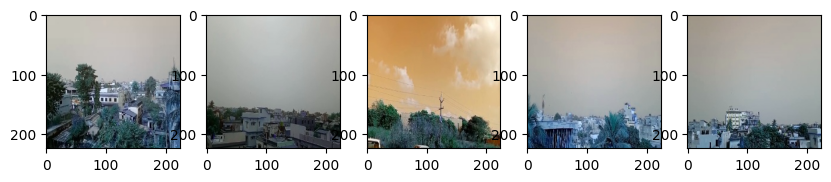

In [7]:
# Visualize some images
import random
# Visualize random images from the dataset
plt.figure(figsize=(10, 10))
# Generate random indices to select images
random_indices = random.sample(range(len(X)), 5)
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[idx])
    #plt.axis('off')  # Hide axis for cleaner visualization
plt.show()

In [8]:
# Initialize a variable to store the total number of samples
total_samples = 0

# Iterate over each directory in the directories dictionary
for label, directory in directories.items():
    # Count the number of files (images) in the current directory
    num_files = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    total_samples += num_files  # Add the count to the total number of samples

    # Print the number of files in the current directory
    print(f"Directory '{label}' has {num_files} images.")

# Print the total number of samples across all directories
print(f"Total number of samples in the dataset: {total_samples}")

Directory 'a' has 1551 images.
Directory 'b' has 1573 images.
Directory 'c' has 2863 images.
Directory 'd' has 2622 images.
Directory 'e' has 2194 images.
Directory 'f' has 1447 images.
Total number of samples in the dataset: 12250


In [9]:
# Define base models
def create_base_model(base_model, input_shape, num_classes):
    base = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    # Add batch normalization for better convergence and stability
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    #x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    #x = Dense(128, activation='relu')(x)
    #x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    #for layer in base.layers:
    #layer.trainable = False
    #x = GlobalAveragePooling2D()(base.output)
    #x = Dense(1024, activation='relu')(x)
    #x = Dense(512, activation='relu')(x)
    #x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=x)
    return model

In [10]:
input_shape = (224, 224, 3)
num_classes = 6

vgg16_model = create_base_model(tf.keras.applications.VGG16, input_shape, num_classes)
vgg19_model = create_base_model(tf.keras.applications.VGG19, input_shape, num_classes)
densenet_model = create_base_model(tf.keras.applications.DenseNet121, input_shape, num_classes)
xception_model = create_base_model(tf.keras.applications.Xception, input_shape, num_classes)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [12]:
from sklearn.model_selection import StratifiedKFold

In [13]:
# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Label encoding for target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=6)

# Stratified splits
for train_index, test_index in kf.split(X, y_encoded):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

In [14]:
# Initialize KFold with 5 splits
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Label encoding for target labels
#le = LabelEncoder()
#y_encoded = le.fit_transform(y)
#y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=6)

In [15]:
from IPython.display import display, HTML

In [16]:
# Initialize fold counter
fold_num = 1
# Perform stratified splitting
for train_index, test_index in kf.split(X, np.argmax(y_categorical, axis=1)):
    #print(f"Fold {fold_num}:")
    # Define the color for highlighting (e.g., light blue)
    highlight_color = "maroon"
    bg_color = "yellow"

    # Display the highlighted fold number
    display(HTML(f'<span style="color:{highlight_color}; background-color:{bg_color}; font-weight: bold;">Fold {fold_num}:</span>'))

    # Split data into training and test sets for the current fold
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Count samples in each class for training and testing sets
    y_train_classes = np.argmax(y_train, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    unique_train, counts_train = np.unique(y_train_classes, return_counts=True)
    unique_test, counts_test = np.unique(y_test_classes, return_counts=True)

    print(f"  Training data: {len(X_train)} samples")
    print(f"  Testing data: {len(X_test)} samples")
    print(f"  Training samples per class: {dict(zip(unique_train, counts_train))}")
    print(f"  Testing samples per class: {dict(zip(unique_test, counts_test))}")

    fold_num += 1

  Training data: 9800 samples
  Testing data: 2450 samples
  Training samples per class: {0: 1240, 1: 1259, 2: 2290, 3: 2098, 4: 1755, 5: 1158}
  Testing samples per class: {0: 311, 1: 314, 2: 573, 3: 524, 4: 439, 5: 289}


  Training data: 9800 samples
  Testing data: 2450 samples
  Training samples per class: {0: 1241, 1: 1258, 2: 2290, 3: 2098, 4: 1755, 5: 1158}
  Testing samples per class: {0: 310, 1: 315, 2: 573, 3: 524, 4: 439, 5: 289}


  Training data: 9800 samples
  Testing data: 2450 samples
  Training samples per class: {0: 1241, 1: 1258, 2: 2291, 3: 2097, 4: 1755, 5: 1158}
  Testing samples per class: {0: 310, 1: 315, 2: 572, 3: 525, 4: 439, 5: 289}


  Training data: 9800 samples
  Testing data: 2450 samples
  Training samples per class: {0: 1241, 1: 1258, 2: 2291, 3: 2097, 4: 1756, 5: 1157}
  Testing samples per class: {0: 310, 1: 315, 2: 572, 3: 525, 4: 438, 5: 290}


  Training data: 9800 samples
  Testing data: 2450 samples
  Training samples per class: {0: 1241, 1: 1259, 2: 2290, 3: 2098, 4: 1755, 5: 1157}
  Testing samples per class: {0: 310, 1: 314, 2: 573, 3: 524, 4: 439, 5: 290}


In [17]:
# Define the VGG16 model creation outside the loop
def create_and_compile_vgg16_model():
    model = create_base_model(tf.keras.applications.VGG16, input_shape=(224, 224, 3), num_classes=6)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall, precision])
    return model

In [18]:
# Define the VGG16 model creation outside the loop
def create_and_compile_vgg19_model():
    model = create_base_model(tf.keras.applications.VGG16, input_shape=(224, 224, 3), num_classes=6)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall, precision])
    return model

In [19]:
# Define the VGG16 model creation outside the loop
def create_and_compile_densenet_model():
    model = create_base_model(tf.keras.applications.VGG16, input_shape=(224, 224, 3), num_classes=6)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall, precision])
    return model

In [20]:
# Define the VGG16 model creation outside the loop
def create_and_compile_xception_model():
    model = create_base_model(tf.keras.applications.VGG16, input_shape=(224, 224, 3), num_classes=6)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall, precision])
    return model

In [21]:
from scipy.stats import mode

In [22]:
from sklearn.metrics import classification_report

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [24]:
# Initialize lists to store metrics
fold_accuracies = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": [], "MajorityVoting": [], "SumRule": []}

fold_train_metrics = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}
fold_val_metrics = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}

fold_train_precision = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}
fold_val_precision = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}
fold_train_recall = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}
fold_val_recall = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}
fold_train_f1 = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}
fold_val_f1 = {"VGG16": [], "VGG19": [], "DenseNet": [], "Xception": []}

fold_majority_voting_precision = []
fold_majority_voting_recall = []
fold_majority_voting_f1 = []
fold_sum_rule_precision = []
fold_sum_rule_recall = []
fold_sum_rule_f1 = []


# Add lists to store metrics
weighted_majority_voting_precision = []
weighted_majority_voting_recall = []
weighted_majority_voting_f1 = []

class_names = ['Good', 'Moderate', 'Unhealthy_for_Sensitive_people', 'Unhealthy', 'Very_unhealthy', 'Severe']
models = {
        "VGG16": create_and_compile_vgg16_model(),
        "VGG19": create_and_compile_vgg19_model(),
        "DenseNet": create_and_compile_densenet_model(),
        "Xception": create_and_compile_xception_model()
        }


# Initialize storage for ROC data for both methods
majority_tprs = {cls: [] for cls in range(len(class_names))}  # Store interpolated TPRs for majority voting
sumrule_tprs = {cls: [] for cls in range(len(class_names))}   # Store interpolated TPRs for sum rule
majority_aucs = {cls: [] for cls in range(len(class_names))}  # Store AUCs for majority voting
sumrule_aucs = {cls: [] for cls in range(len(class_names))}   # Store AUCs for sum rule
mean_fpr = np.linspace(0, 1, 100)  # Define a common FPR scale


# Initialize dictionaries to store accuracies for all models across folds
avg_train_accuracies = {model_name: [] for model_name in models.keys()}
avg_val_accuracies = {model_name: [] for model_name in models.keys()}

# Initialize dictionaries to accumulate accuracies across folds
train_accuracies_all_folds = {model_name: [] for model_name in models.keys()}
val_accuracies_all_folds = {model_name: [] for model_name in models.keys()}



Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 82s 217ms/step - accuracy: 0.7109 - f1_score: 0.8600 - loss: 0.7816 - precision: 0.8554 - recall: 0.8710 - val_accuracy: 0.9098 - val_f1_score: 0.8489 - val_loss: 0.2433 - val_precision: 0.8582 - val_recall: 0.8451
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9217 - f1_score: 0.9567 - loss: 0.2210 - precision: 0.9581 - recall: 0.9573 - val_accuracy: 0.9404 - val_f1_score: 0.8552 - val_loss: 0.1893 - val_precision: 0.8586 - val_recall: 0.8543
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9544 - f1_score: 0.9744 - loss: 0.1332 - precision: 0.9746 - recall: 0.9750 - val_accuracy: 0.9653 - val_f1_score: 0.8697 - val_loss: 0.1156 - val_precision: 0.8685 - val_recall: 0.8719
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9703 - f1_score: 0.9832 - loss: 0.0866 - precision: 0.9831 - recall: 0.9839 - val_accuracy: 0.9555 - val_f1_score: 0.8643 - val_loss: 0.1445 - val_precision: 0.8755 -

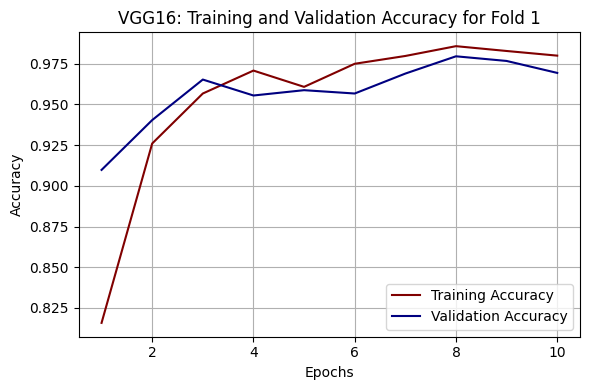

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.7107 - f1_score: 0.8554 - loss: 0.7816 - precision: 0.8564 - recall: 0.8625 - val_accuracy: 0.9216 - val_f1_score: 0.8520 - val_loss: 0.2319 - val_precision: 0.8520 - val_recall: 0.8558
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9351 - f1_score: 0.9639 - loss: 0.1888 - precision: 0.9626 - recall: 0.9665 - val_accuracy: 0.9216 - val_f1_score: 0.8537 - val_loss: 0.2078 - val_precision: 0.8497 - val_recall: 0.8623
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9489 - f1_score: 0.9717 - loss: 0.1481 - precision: 0.9731 - recall: 0.9716 - val_accuracy: 0.9571 - val_f1_score: 0.8664 - val_loss: 0.1311 - val_precision: 0.8706 - val_recall: 0.8642
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9662 - f1_score: 0.9811 - loss: 0.1063 - precision: 0.9800 - recall: 0.9829 - val_accuracy: 0.9531 - val_f1_score: 0.8640 - val_loss: 0.1574 - val_precision: 0.8739 -

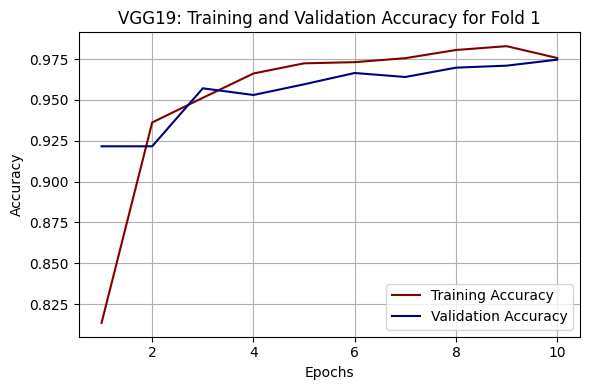

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.7105 - f1_score: 0.8563 - loss: 0.7933 - precision: 0.8535 - recall: 0.8629 - val_accuracy: 0.8763 - val_f1_score: 0.8218 - val_loss: 0.3484 - val_precision: 0.8429 - val_recall: 0.8128
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9170 - f1_score: 0.9544 - loss: 0.2161 - precision: 0.9564 - recall: 0.9541 - val_accuracy: 0.9482 - val_f1_score: 0.8636 - val_loss: 0.1636 - val_precision: 0.8615 - val_recall: 0.8674
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9628 - f1_score: 0.9792 - loss: 0.1139 - precision: 0.9803 - recall: 0.9788 - val_accuracy: 0.9653 - val_f1_score: 0.8706 - val_loss: 0.1144 - val_precision: 0.8747 - val_recall: 0.8675
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9619 - f1_score: 0.9787 - loss: 0.1082 - precision: 0.9806 - recall: 0.9777 - val_accuracy: 0.9584 - val_f1_score: 0.8651 - val_loss: 0.1206 - val_precision: 0.8679 -

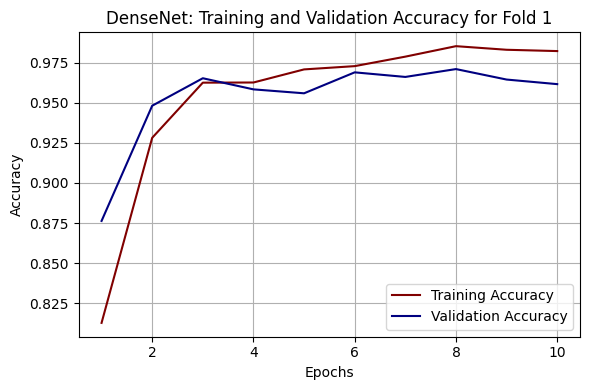

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.6976 - f1_score: 0.8533 - loss: 0.8060 - precision: 0.8485 - recall: 0.8627 - val_accuracy: 0.9208 - val_f1_score: 0.8538 - val_loss: 0.2444 - val_precision: 0.8549 - val_recall: 0.8577
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9290 - f1_score: 0.9611 - loss: 0.2121 - precision: 0.9608 - recall: 0.9625 - val_accuracy: 0.9086 - val_f1_score: 0.8444 - val_loss: 0.2436 - val_precision: 0.8393 - val_recall: 0.8566
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9487 - f1_score: 0.9716 - loss: 0.1419 - precision: 0.9715 - recall: 0.9729 - val_accuracy: 0.9478 - val_f1_score: 0.8629 - val_loss: 0.1703 - val_precision: 0.8628 - val_recall: 0.8646
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9599 - f1_score: 0.9773 - loss: 0.1144 - precision: 0.9771 - recall: 0.9785 - val_accuracy: 0.9612 - val_f1_score: 0.8672 - val_loss: 0.1221 - val_precision: 0.8657 -

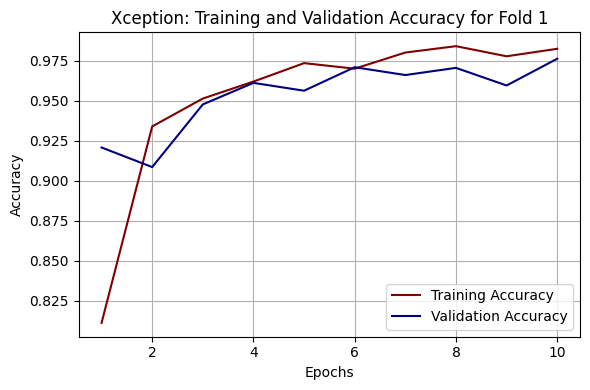


Test Parameter                     Majority Voting          Sum Rule                 Weighted Majority Voting      
--------------------------------------------------------------------------------------------------------------
Accuracy:                          0.9820                   0.9865                   0.9824                        
F1 Score:                          0.9820                   0.9860                   0.9825                        
Precision:                         0.9817                   0.9856                   0.9822                        
Recall:                            0.9823                   0.9865                   0.9829                        




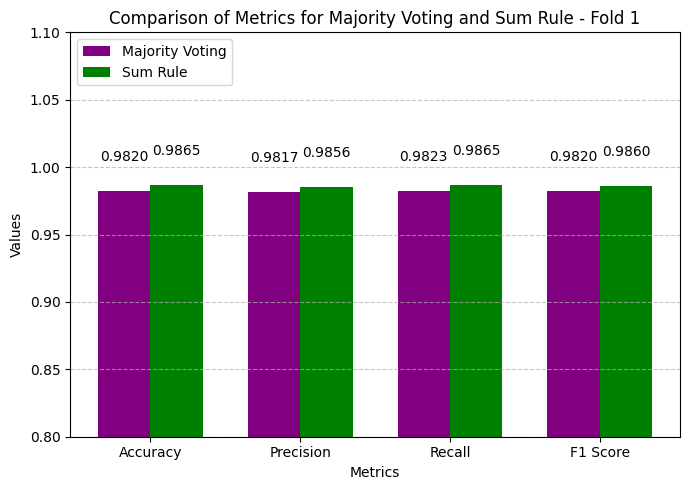

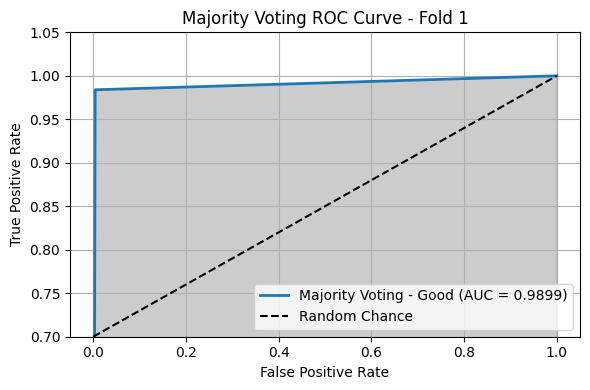

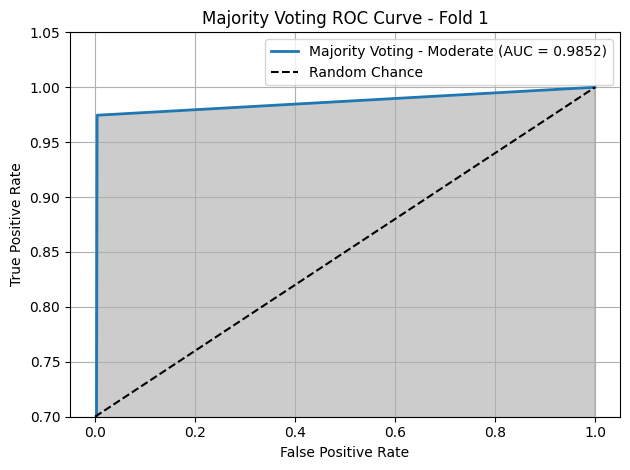

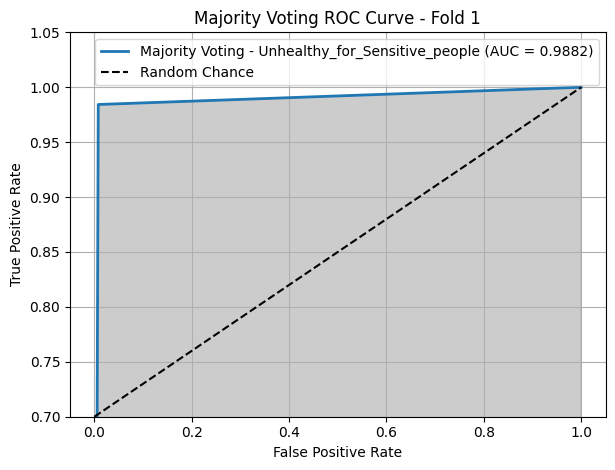

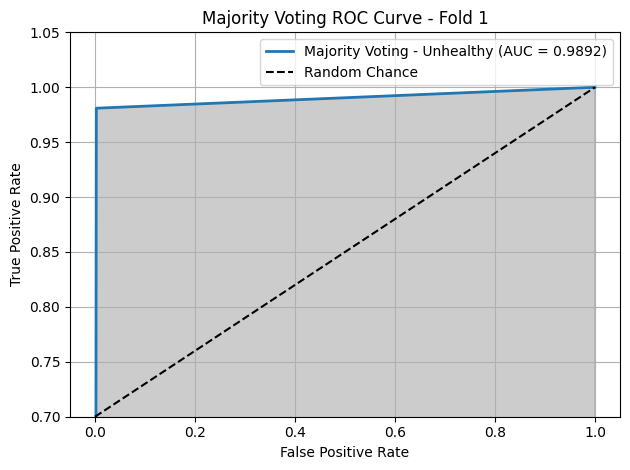

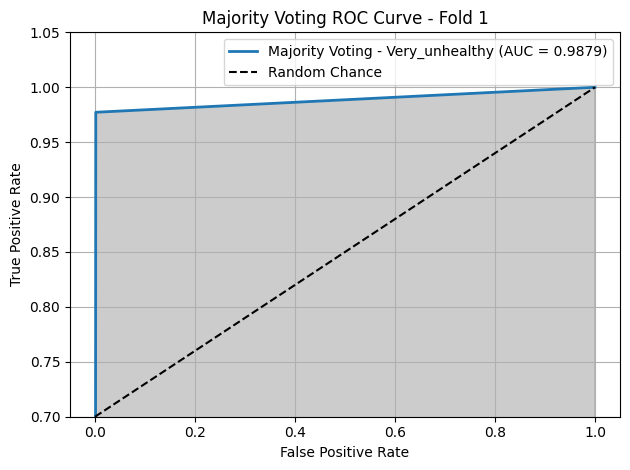

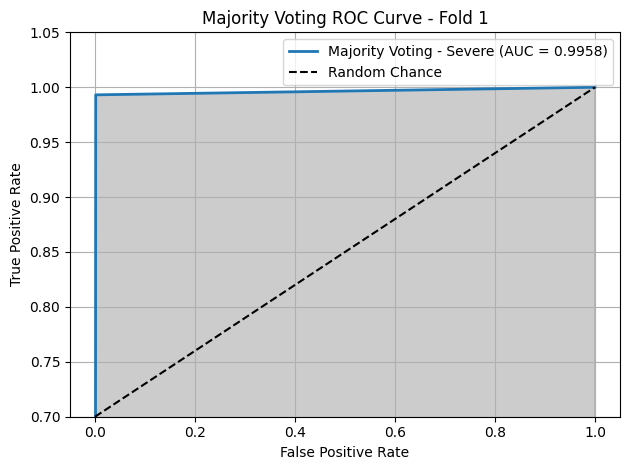

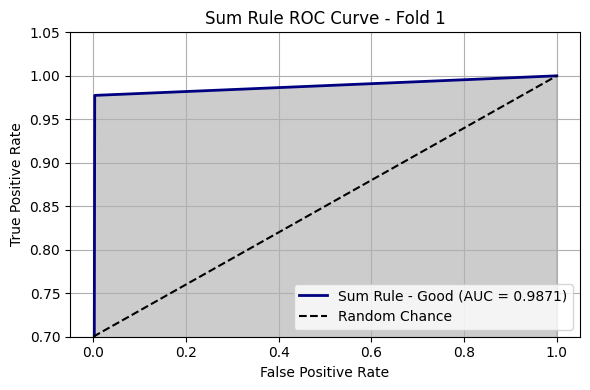

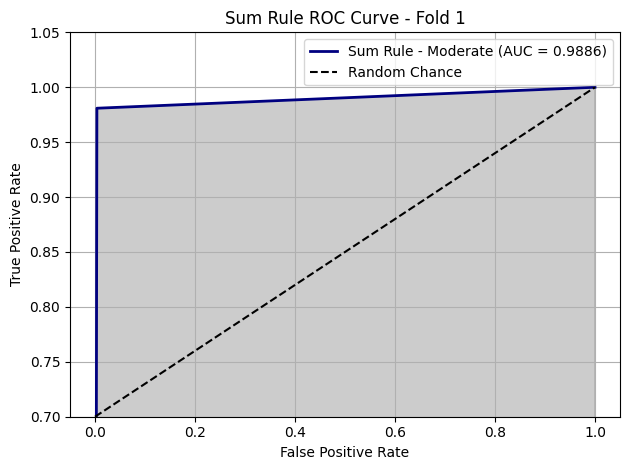

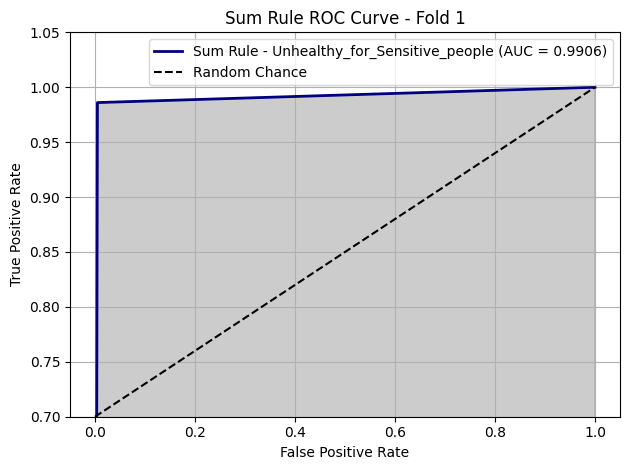

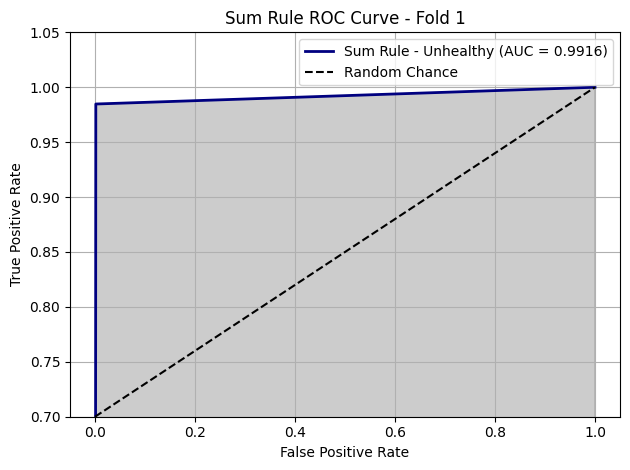

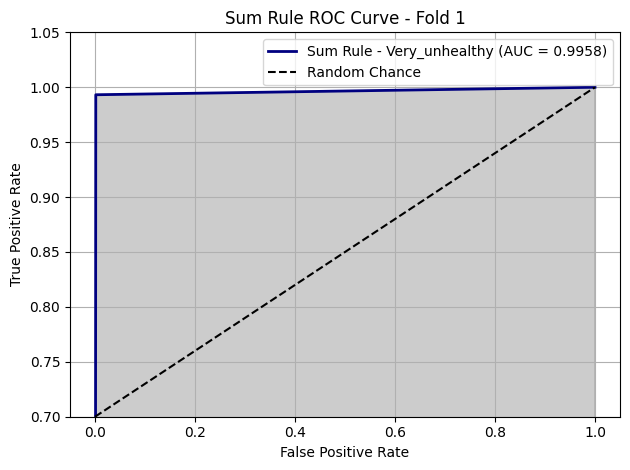

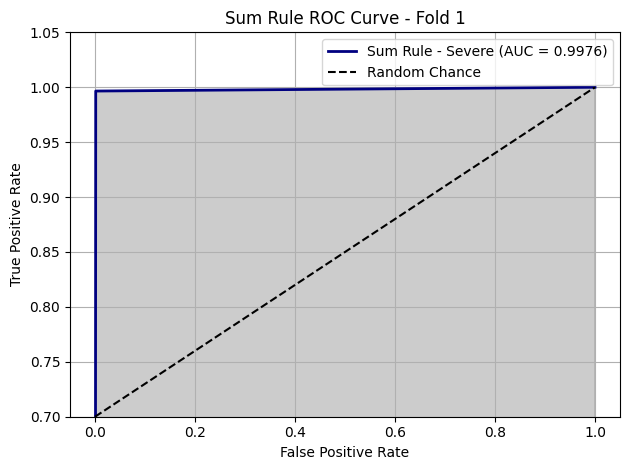

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 180ms/step - accuracy: 0.7135 - f1_score: 0.8574 - loss: 0.7853 - precision: 0.8508 - recall: 0.8704 - val_accuracy: 0.9167 - val_f1_score: 0.8488 - val_loss: 0.2270 - val_precision: 0.8412 - val_recall: 0.8622
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9302 - f1_score: 0.9614 - loss: 0.1977 - precision: 0.9609 - recall: 0.9632 - val_accuracy: 0.9257 - val_f1_score: 0.8504 - val_loss: 0.2014 - val_precision: 0.8493 - val_recall: 0.8553
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9566 - f1_score: 0.9754 - loss: 0.1238 - precision: 0.9743 - recall: 0.9776 - val_accuracy: 0.9563 - val_f1_score: 0.8643 - val_loss: 0.1474 - val_precision: 0.8658 - val_recall: 0.8642
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9589 - f1_score: 0.9770 - loss: 0.1177 - precision: 0.9787 - recall: 0.9763 - val_accuracy: 0.9686 - val_f1_score: 0.8683 - val_loss: 0.1032 - val_precision: 0.8692 -

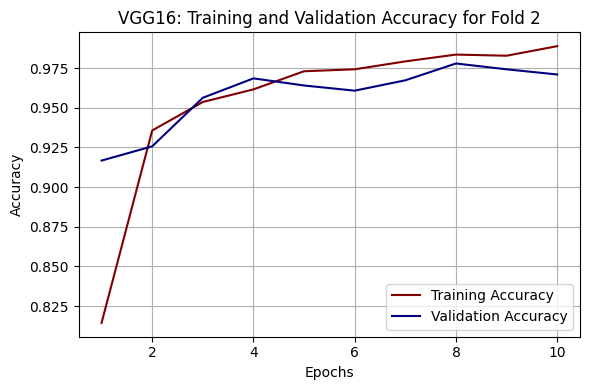

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.7130 - f1_score: 0.8584 - loss: 0.7868 - precision: 0.8490 - recall: 0.8726 - val_accuracy: 0.9237 - val_f1_score: 0.8541 - val_loss: 0.2258 - val_precision: 0.8697 - val_recall: 0.8430
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9284 - f1_score: 0.9606 - loss: 0.1991 - precision: 0.9624 - recall: 0.9606 - val_accuracy: 0.9400 - val_f1_score: 0.8560 - val_loss: 0.2121 - val_precision: 0.8612 - val_recall: 0.8538
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9455 - f1_score: 0.9696 - loss: 0.1507 - precision: 0.9713 - recall: 0.9691 - val_accuracy: 0.9555 - val_f1_score: 0.8665 - val_loss: 0.1331 - val_precision: 0.8686 - val_recall: 0.8665
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9667 - f1_score: 0.9813 - loss: 0.1035 - precision: 0.9820 - recall: 0.9813 - val_accuracy: 0.9535 - val_f1_score: 0.8630 - val_loss: 0.1478 - val_precision: 0.8671 -

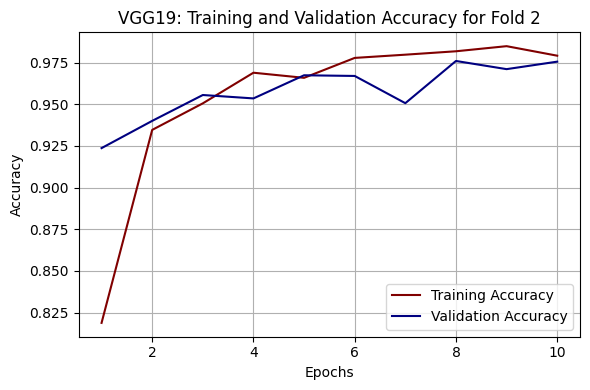

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.7019 - f1_score: 0.8554 - loss: 0.7894 - precision: 0.8492 - recall: 0.8674 - val_accuracy: 0.9290 - val_f1_score: 0.8555 - val_loss: 0.2061 - val_precision: 0.8487 - val_recall: 0.8665
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9332 - f1_score: 0.9628 - loss: 0.1881 - precision: 0.9596 - recall: 0.9677 - val_accuracy: 0.9478 - val_f1_score: 0.8613 - val_loss: 0.1602 - val_precision: 0.8623 - val_recall: 0.8619
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9553 - f1_score: 0.9750 - loss: 0.1269 - precision: 0.9752 - recall: 0.9756 - val_accuracy: 0.9482 - val_f1_score: 0.8617 - val_loss: 0.1586 - val_precision: 0.8566 - val_recall: 0.8700
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9649 - f1_score: 0.9806 - loss: 0.1001 - precision: 0.9802 - recall: 0.9816 - val_accuracy: 0.9678 - val_f1_score: 0.8699 - val_loss: 0.1017 - val_precision: 0.8761 -

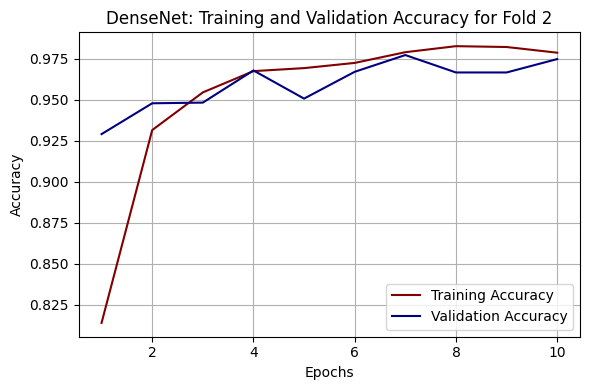

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.7130 - f1_score: 0.8574 - loss: 0.7826 - precision: 0.8526 - recall: 0.8687 - val_accuracy: 0.9237 - val_f1_score: 0.8532 - val_loss: 0.2238 - val_precision: 0.8594 - val_recall: 0.8508
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9252 - f1_score: 0.9591 - loss: 0.2124 - precision: 0.9597 - recall: 0.9603 - val_accuracy: 0.9563 - val_f1_score: 0.8685 - val_loss: 0.1382 - val_precision: 0.8735 - val_recall: 0.8651
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9578 - f1_score: 0.9764 - loss: 0.1248 - precision: 0.9768 - recall: 0.9768 - val_accuracy: 0.9449 - val_f1_score: 0.8636 - val_loss: 0.1769 - val_precision: 0.8678 - val_recall: 0.8611
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9659 - f1_score: 0.9809 - loss: 0.1061 - precision: 0.9806 - recall: 0.9819 - val_accuracy: 0.9592 - val_f1_score: 0.8667 - val_loss: 0.1250 - val_precision: 0.8677 -

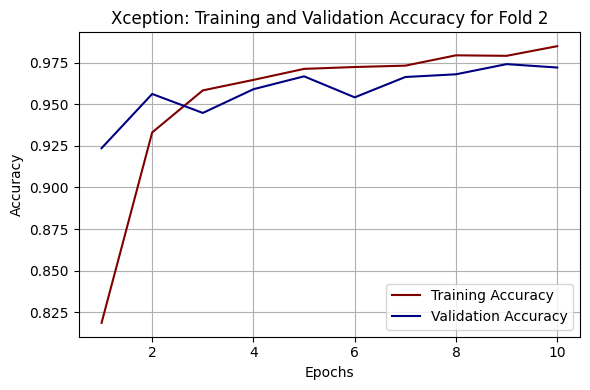


Test Parameter                     Majority Voting          Sum Rule                 Weighted Majority Voting      
--------------------------------------------------------------------------------------------------------------
Accuracy:                          0.9833                   0.9849                   0.9841                        
F1 Score:                          0.9824                   0.9844                   0.9834                        
Precision:                         0.9822                   0.9842                   0.9833                        
Recall:                            0.9828                   0.9847                   0.9836                        




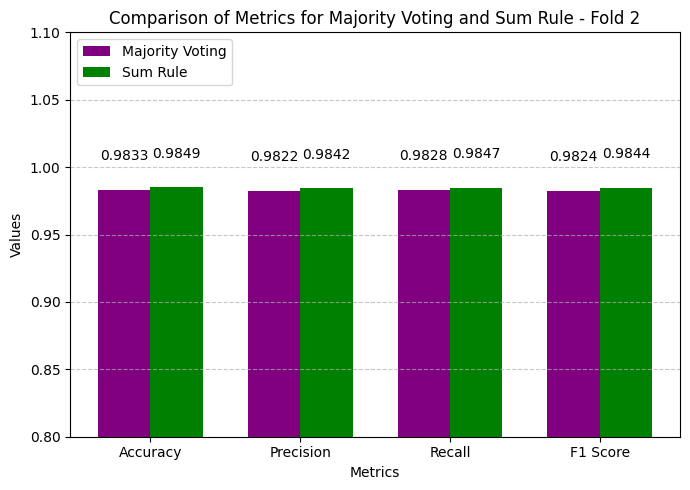

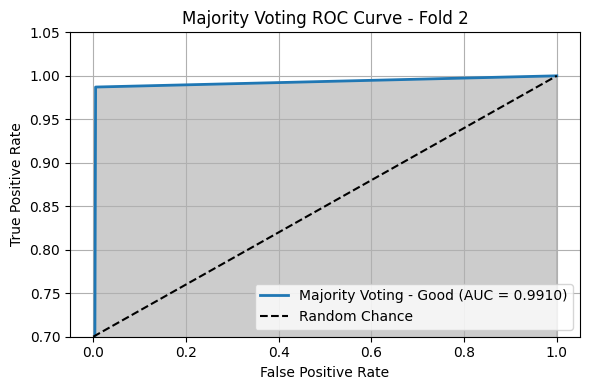

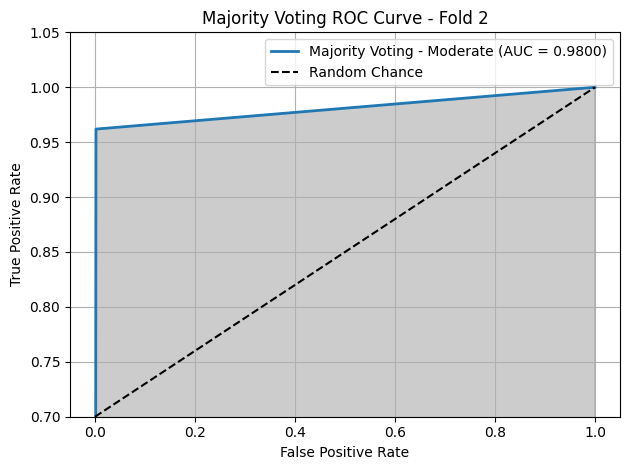

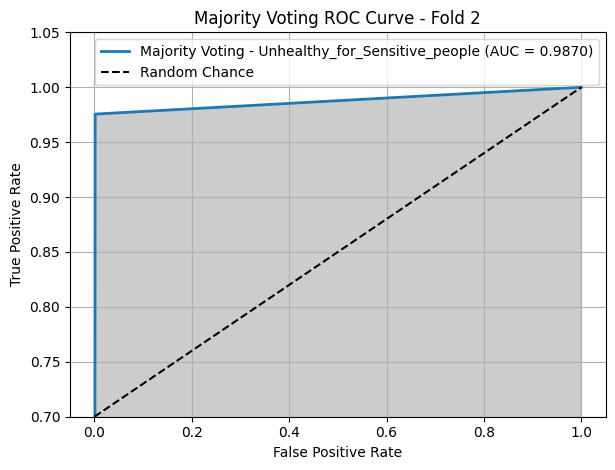

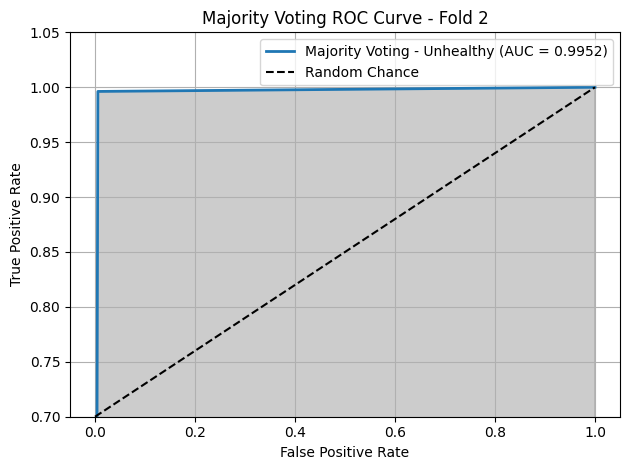

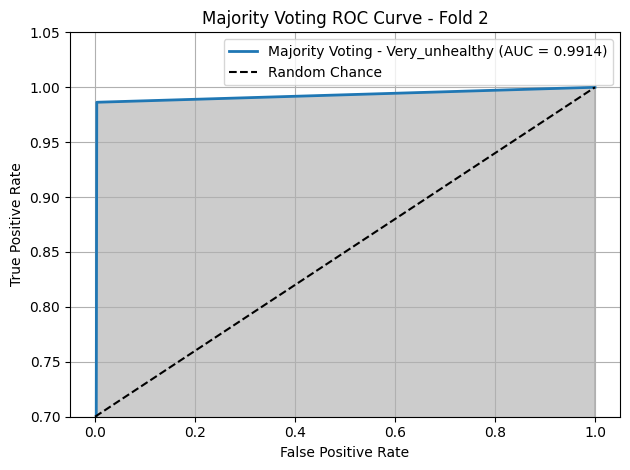

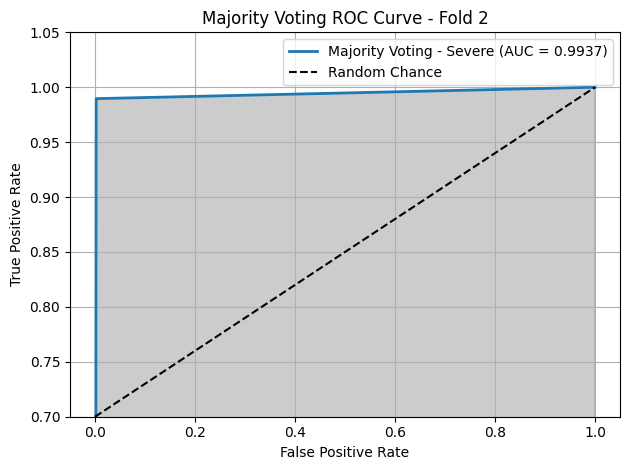

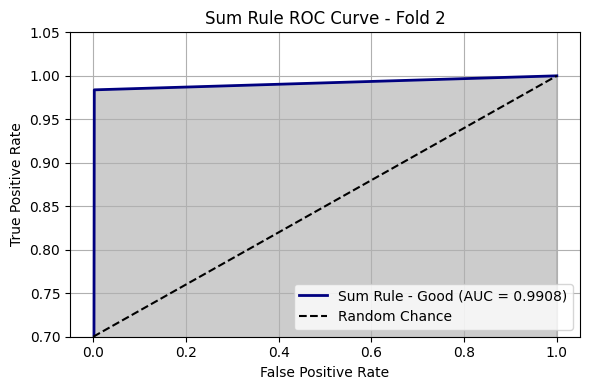

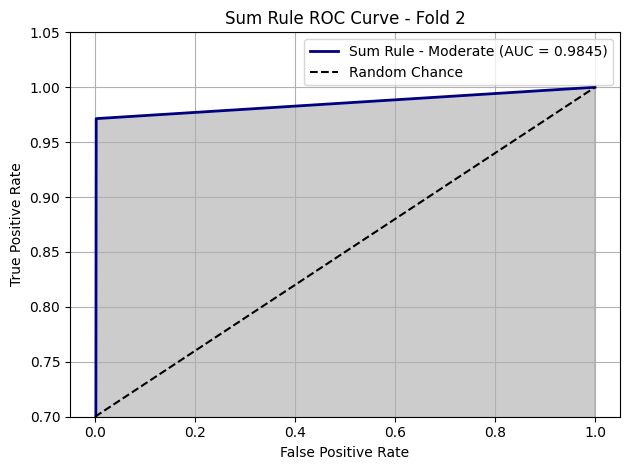

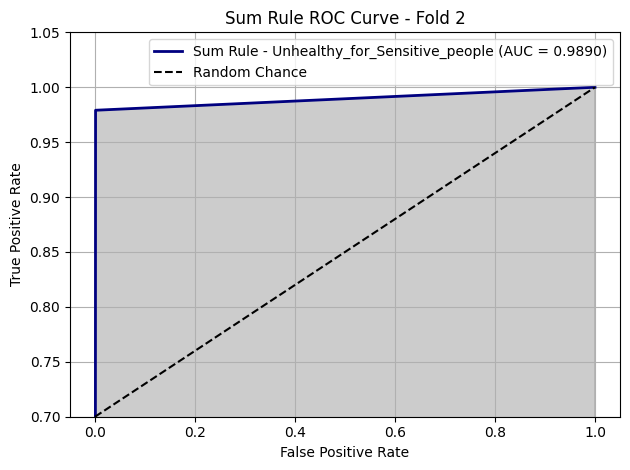

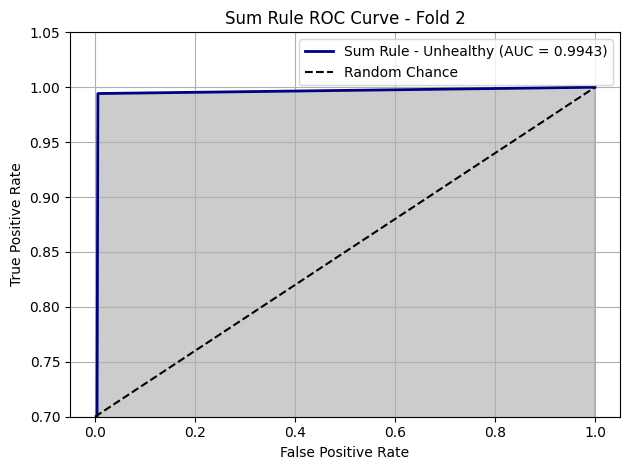

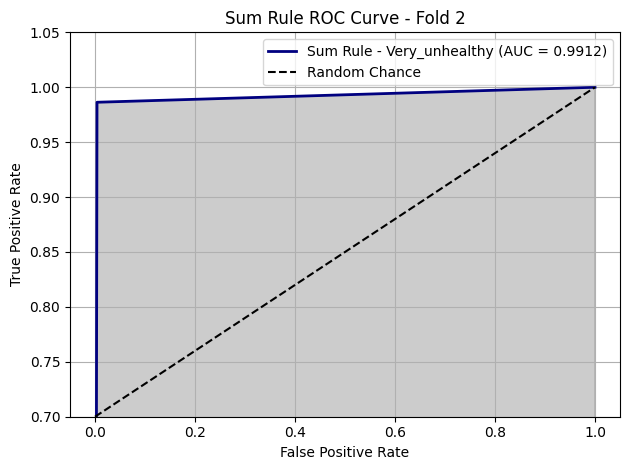

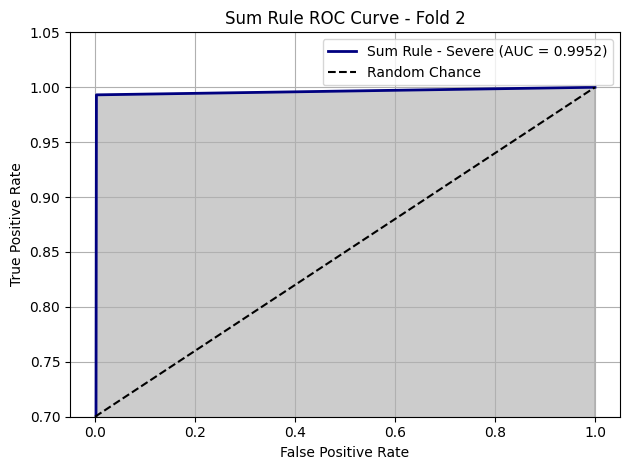

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.6990 - f1_score: 0.8532 - loss: 0.7971 - precision: 0.8480 - recall: 0.8647 - val_accuracy: 0.9192 - val_f1_score: 0.8455 - val_loss: 0.2185 - val_precision: 0.8630 - val_recall: 0.8329
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9301 - f1_score: 0.9609 - loss: 0.1892 - precision: 0.9620 - recall: 0.9612 - val_accuracy: 0.9433 - val_f1_score: 0.8589 - val_loss: 0.1655 - val_precision: 0.8744 - val_recall: 0.8464
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9468 - f1_score: 0.9703 - loss: 0.1503 - precision: 0.9721 - recall: 0.9695 - val_accuracy: 0.9449 - val_f1_score: 0.8616 - val_loss: 0.1641 - val_precision: 0.8765 - val_recall: 0.8504
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9624 - f1_score: 0.9788 - loss: 0.1103 - precision: 0.9784 - recall: 0.9800 - val_accuracy: 0.9563 - val_f1_score: 0.8640 - val_loss: 0.1243 - val_precision: 0.8688 -

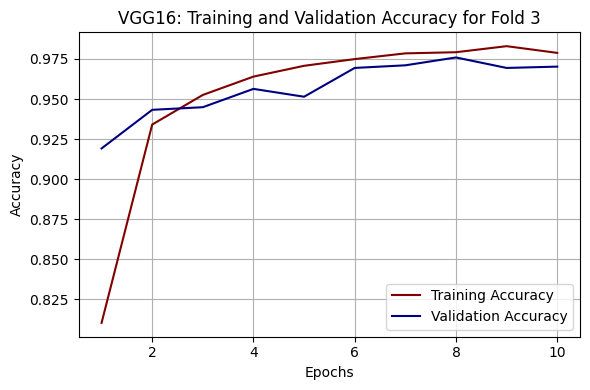

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.7012 - f1_score: 0.8557 - loss: 0.7955 - precision: 0.8505 - recall: 0.8668 - val_accuracy: 0.9208 - val_f1_score: 0.8554 - val_loss: 0.2452 - val_precision: 0.8744 - val_recall: 0.8418
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9330 - f1_score: 0.9632 - loss: 0.1906 - precision: 0.9636 - recall: 0.9643 - val_accuracy: 0.9445 - val_f1_score: 0.8584 - val_loss: 0.1710 - val_precision: 0.8527 - val_recall: 0.8674
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9609 - f1_score: 0.9781 - loss: 0.1187 - precision: 0.9770 - recall: 0.9802 - val_accuracy: 0.9506 - val_f1_score: 0.8611 - val_loss: 0.1651 - val_precision: 0.8664 - val_recall: 0.8574
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9598 - f1_score: 0.9775 - loss: 0.1212 - precision: 0.9768 - recall: 0.9791 - val_accuracy: 0.9608 - val_f1_score: 0.8633 - val_loss: 0.1245 - val_precision: 0.8697 -

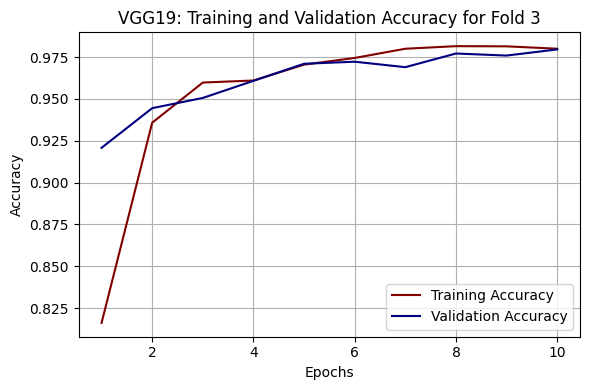

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.7018 - f1_score: 0.8499 - loss: 0.8010 - precision: 0.8497 - recall: 0.8557 - val_accuracy: 0.9331 - val_f1_score: 0.8530 - val_loss: 0.2192 - val_precision: 0.8688 - val_recall: 0.8411
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9256 - f1_score: 0.9589 - loss: 0.2094 - precision: 0.9591 - recall: 0.9604 - val_accuracy: 0.9559 - val_f1_score: 0.8650 - val_loss: 0.1445 - val_precision: 0.8668 - val_recall: 0.8646
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9531 - f1_score: 0.9735 - loss: 0.1244 - precision: 0.9747 - recall: 0.9735 - val_accuracy: 0.9616 - val_f1_score: 0.8683 - val_loss: 0.1341 - val_precision: 0.8707 - val_recall: 0.8669
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9661 - f1_score: 0.9811 - loss: 0.0969 - precision: 0.9808 - recall: 0.9823 - val_accuracy: 0.9608 - val_f1_score: 0.8645 - val_loss: 0.1357 - val_precision: 0.8699 -

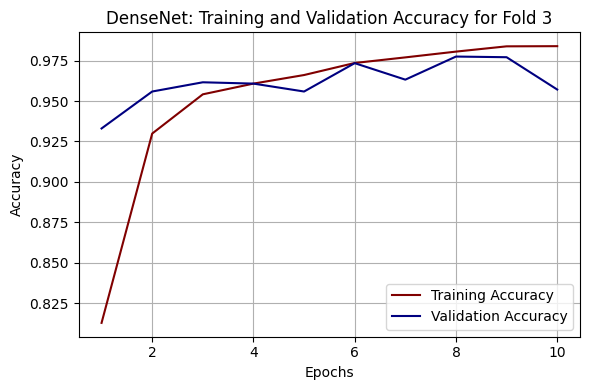

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.7089 - f1_score: 0.8563 - loss: 0.7806 - precision: 0.8528 - recall: 0.8663 - val_accuracy: 0.9196 - val_f1_score: 0.8458 - val_loss: 0.2260 - val_precision: 0.8542 - val_recall: 0.8425
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9219 - f1_score: 0.9573 - loss: 0.2161 - precision: 0.9538 - recall: 0.9628 - val_accuracy: 0.9359 - val_f1_score: 0.8536 - val_loss: 0.1942 - val_precision: 0.8685 - val_recall: 0.8415
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9471 - f1_score: 0.9700 - loss: 0.1438 - precision: 0.9716 - recall: 0.9696 - val_accuracy: 0.9620 - val_f1_score: 0.8657 - val_loss: 0.1213 - val_precision: 0.8696 - val_recall: 0.8633
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9673 - f1_score: 0.9819 - loss: 0.0987 - precision: 0.9824 - recall: 0.9821 - val_accuracy: 0.9571 - val_f1_score: 0.8642 - val_loss: 0.1275 - val_precision: 0.8711 -

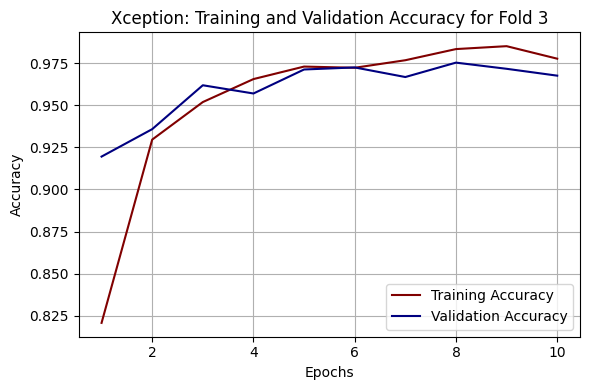


Test Parameter                     Majority Voting          Sum Rule                 Weighted Majority Voting      
--------------------------------------------------------------------------------------------------------------
Accuracy:                          0.9816                   0.9869                   0.9841                        
F1 Score:                          0.9811                   0.9864                   0.9837                        
Precision:                         0.9811                   0.9867                   0.9838                        
Recall:                            0.9813                   0.9862                   0.9836                        




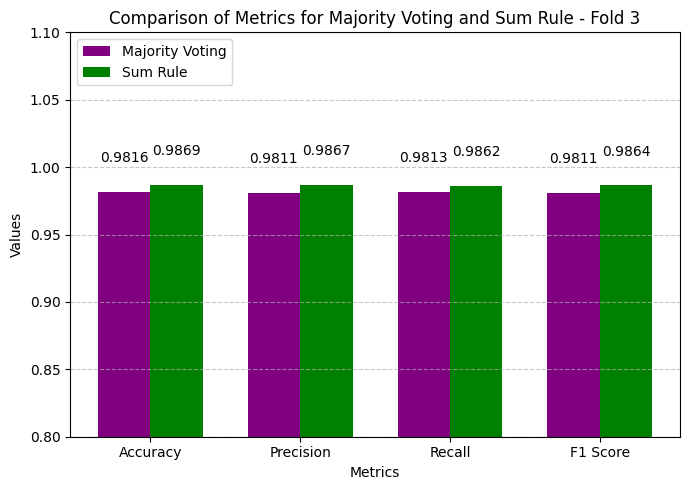

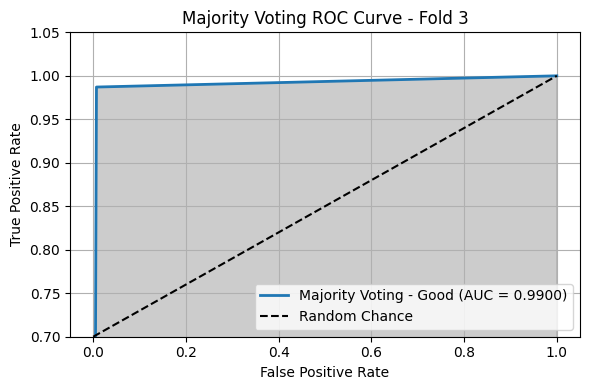

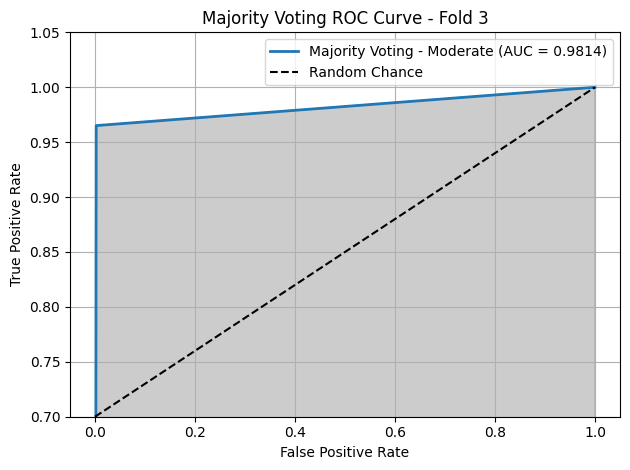

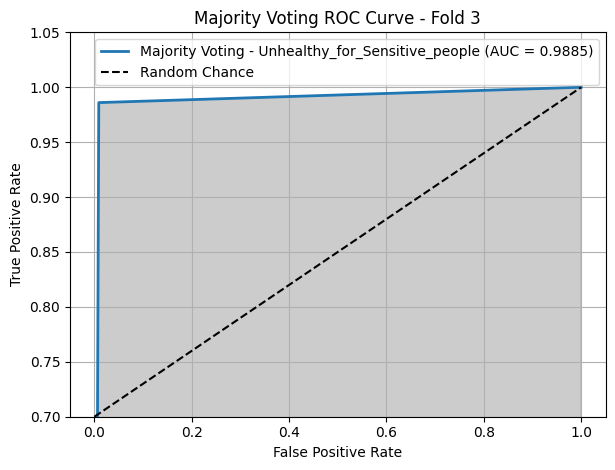

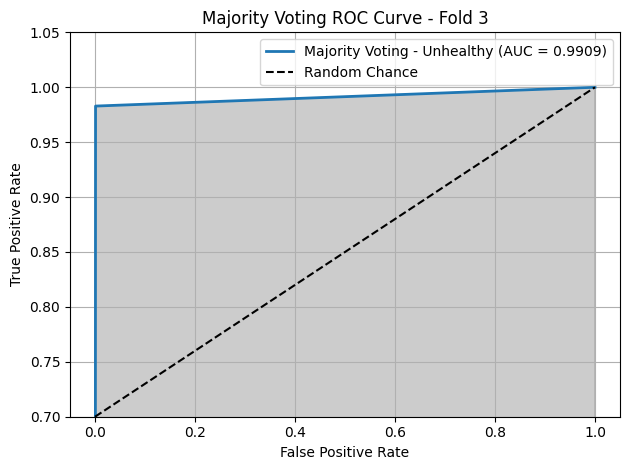

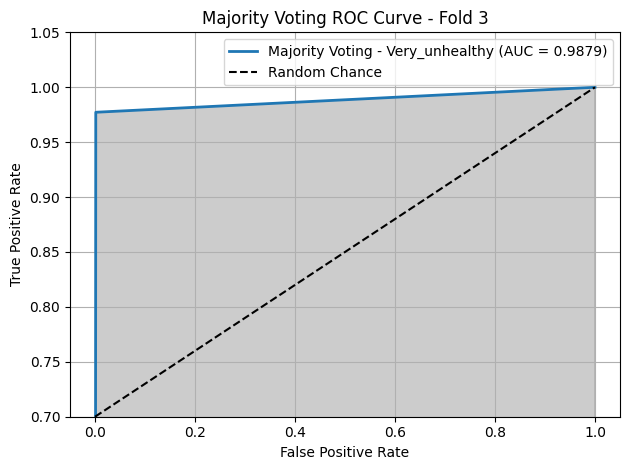

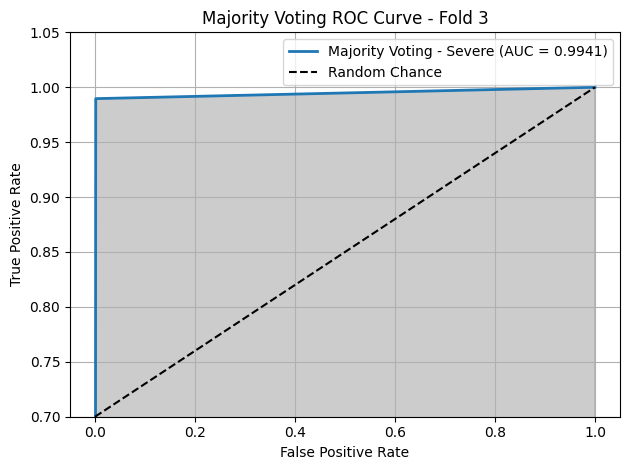

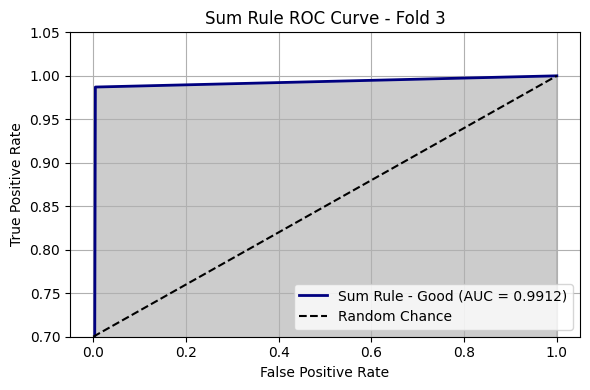

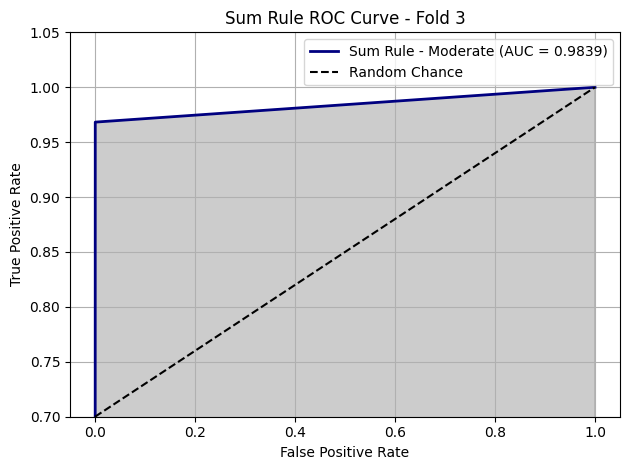

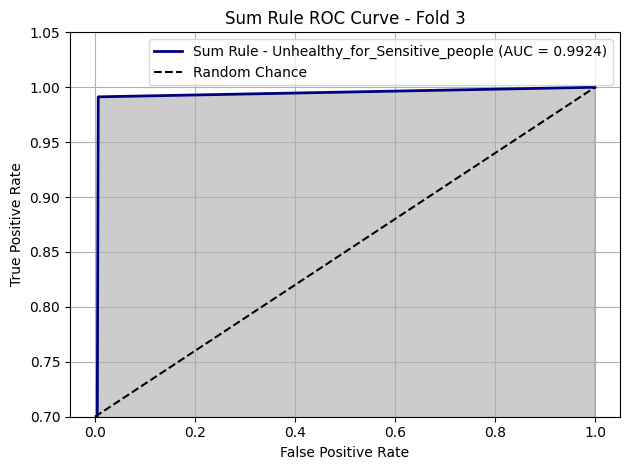

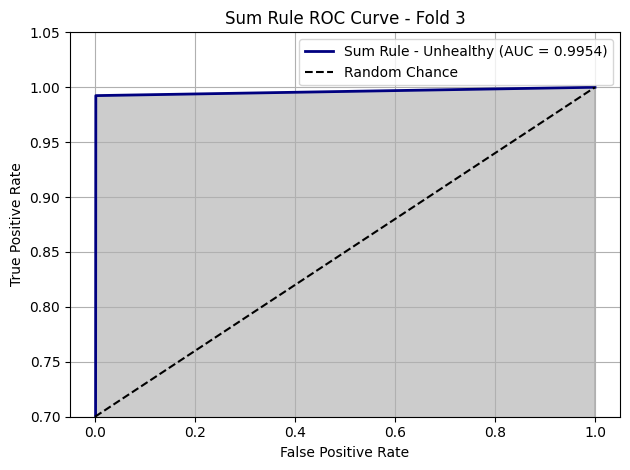

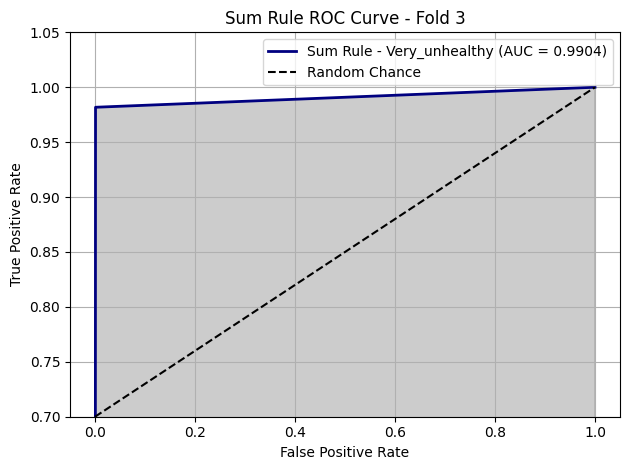

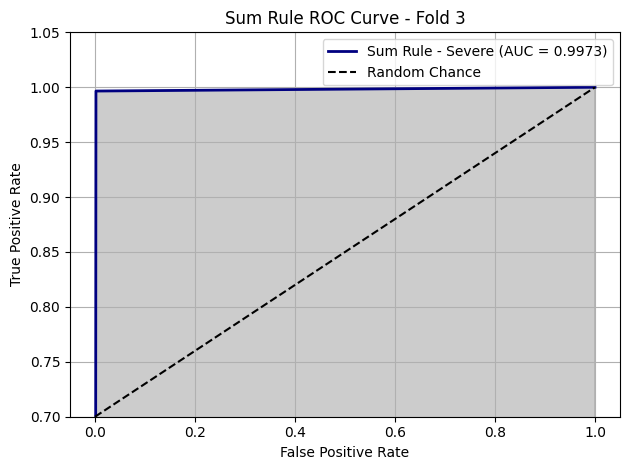

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.7135 - f1_score: 0.8578 - loss: 0.7969 - precision: 0.8510 - recall: 0.8697 - val_accuracy: 0.9196 - val_f1_score: 0.8511 - val_loss: 0.2151 - val_precision: 0.8486 - val_recall: 0.8575
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9247 - f1_score: 0.9579 - loss: 0.2067 - precision: 0.9586 - recall: 0.9591 - val_accuracy: 0.9416 - val_f1_score: 0.8578 - val_loss: 0.1744 - val_precision: 0.8507 - val_recall: 0.8673
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9445 - f1_score: 0.9691 - loss: 0.1588 - precision: 0.9670 - recall: 0.9722 - val_accuracy: 0.9527 - val_f1_score: 0.8625 - val_loss: 0.1370 - val_precision: 0.8644 - val_recall: 0.8633
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9643 - f1_score: 0.9801 - loss: 0.1007 - precision: 0.9818 - recall: 0.9791 - val_accuracy: 0.9531 - val_f1_score: 0.8621 - val_loss: 0.1432 - val_precision: 0.8527 -

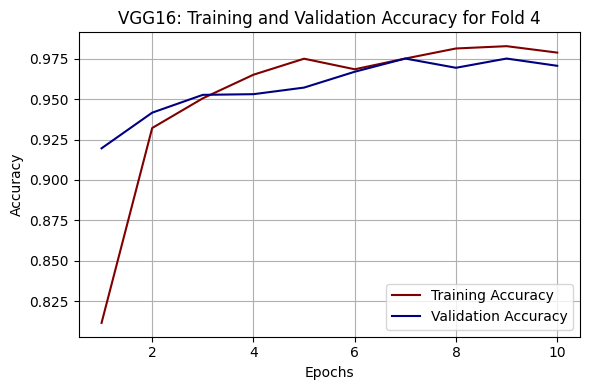

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.6929 - f1_score: 0.8527 - loss: 0.8092 - precision: 0.8492 - recall: 0.8617 - val_accuracy: 0.8971 - val_f1_score: 0.8423 - val_loss: 0.3040 - val_precision: 0.8346 - val_recall: 0.8561
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9277 - f1_score: 0.9603 - loss: 0.2086 - precision: 0.9595 - recall: 0.9627 - val_accuracy: 0.9469 - val_f1_score: 0.8630 - val_loss: 0.1512 - val_precision: 0.8568 - val_recall: 0.8713
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9622 - f1_score: 0.9788 - loss: 0.1190 - precision: 0.9776 - recall: 0.9809 - val_accuracy: 0.9498 - val_f1_score: 0.8604 - val_loss: 0.1278 - val_precision: 0.8611 - val_recall: 0.8621
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9627 - f1_score: 0.9789 - loss: 0.0956 - precision: 0.9786 - recall: 0.9800 - val_accuracy: 0.9571 - val_f1_score: 0.8651 - val_loss: 0.1376 - val_precision: 0.8692 -

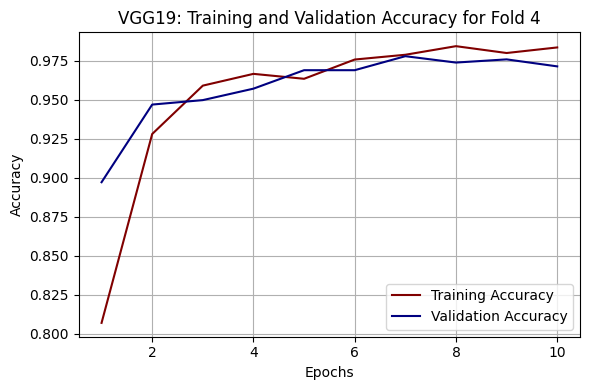

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.7005 - f1_score: 0.8536 - loss: 0.8146 - precision: 0.8459 - recall: 0.8680 - val_accuracy: 0.9122 - val_f1_score: 0.8462 - val_loss: 0.2548 - val_precision: 0.8585 - val_recall: 0.8380
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9235 - f1_score: 0.9581 - loss: 0.2247 - precision: 0.9603 - recall: 0.9576 - val_accuracy: 0.9453 - val_f1_score: 0.8610 - val_loss: 0.1538 - val_precision: 0.8712 - val_recall: 0.8528
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9610 - f1_score: 0.9782 - loss: 0.1156 - precision: 0.9788 - recall: 0.9784 - val_accuracy: 0.9547 - val_f1_score: 0.8657 - val_loss: 0.1444 - val_precision: 0.8764 - val_recall: 0.8572
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9596 - f1_score: 0.9777 - loss: 0.1139 - precision: 0.9779 - recall: 0.9782 - val_accuracy: 0.9714 - val_f1_score: 0.8689 - val_loss: 0.0996 - val_precision: 0.8673 -

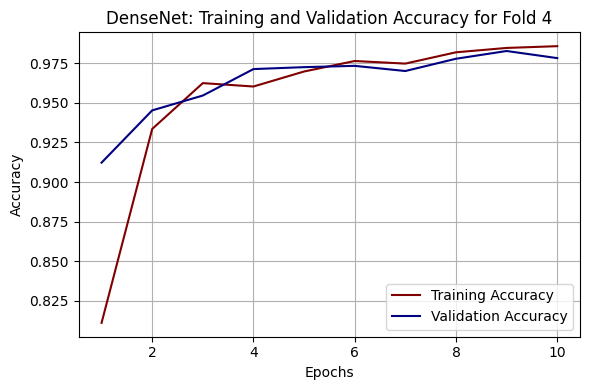

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.6991 - f1_score: 0.8500 - loss: 0.8125 - precision: 0.8477 - recall: 0.8592 - val_accuracy: 0.9208 - val_f1_score: 0.8506 - val_loss: 0.2287 - val_precision: 0.8412 - val_recall: 0.8640
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9233 - f1_score: 0.9581 - loss: 0.2179 - precision: 0.9563 - recall: 0.9613 - val_accuracy: 0.9551 - val_f1_score: 0.8673 - val_loss: 0.1371 - val_precision: 0.8695 - val_recall: 0.8664
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9602 - f1_score: 0.9778 - loss: 0.1198 - precision: 0.9777 - recall: 0.9787 - val_accuracy: 0.9510 - val_f1_score: 0.8654 - val_loss: 0.1367 - val_precision: 0.8683 - val_recall: 0.8650
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9679 - f1_score: 0.9821 - loss: 0.0979 - precision: 0.9814 - recall: 0.9834 - val_accuracy: 0.9686 - val_f1_score: 0.8707 - val_loss: 0.1054 - val_precision: 0.8696 -

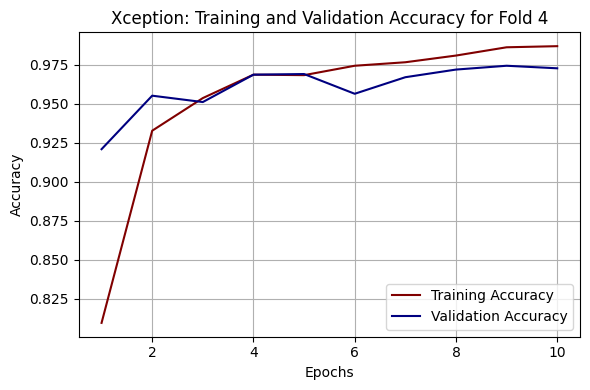


Test Parameter                     Majority Voting          Sum Rule                 Weighted Majority Voting      
--------------------------------------------------------------------------------------------------------------
Accuracy:                          0.9878                   0.9878                   0.9878                        
F1 Score:                          0.9880                   0.9881                   0.9880                        
Precision:                         0.9879                   0.9878                   0.9879                        
Recall:                            0.9882                   0.9883                   0.9882                        




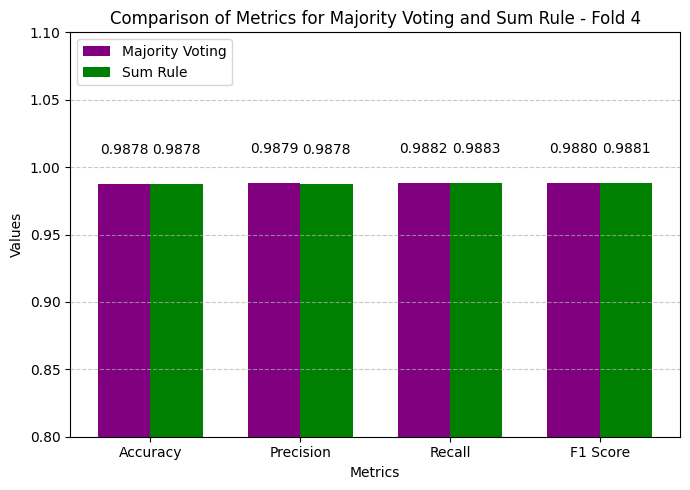

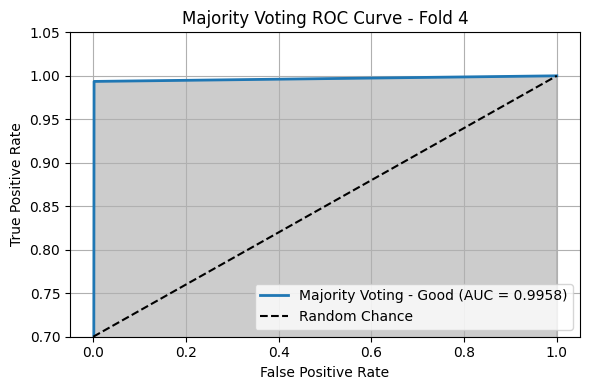

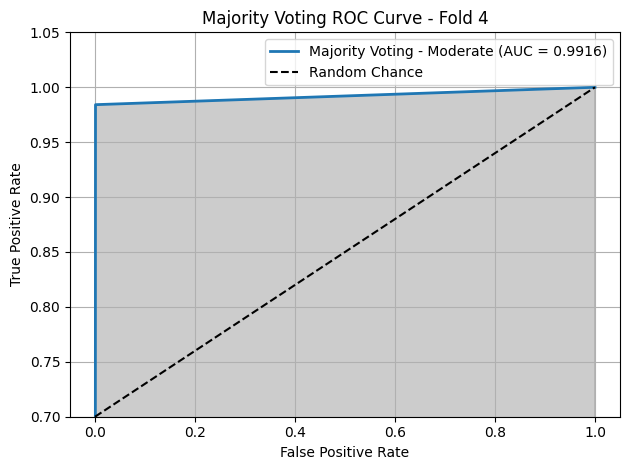

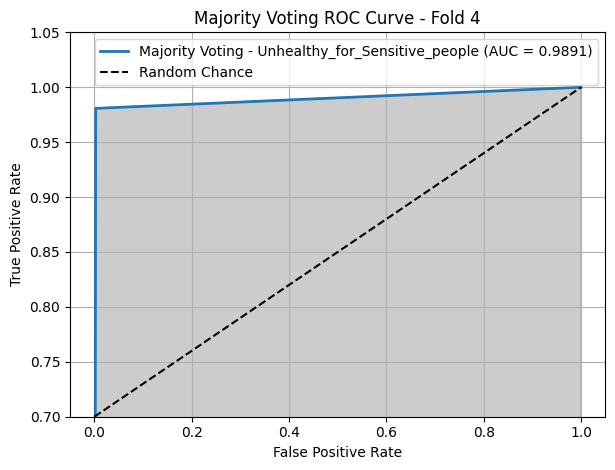

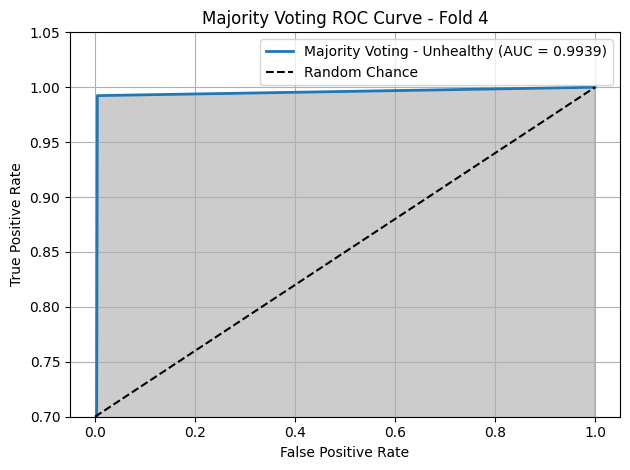

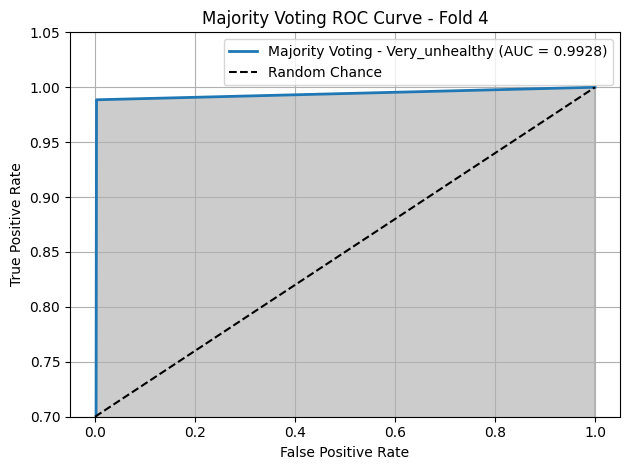

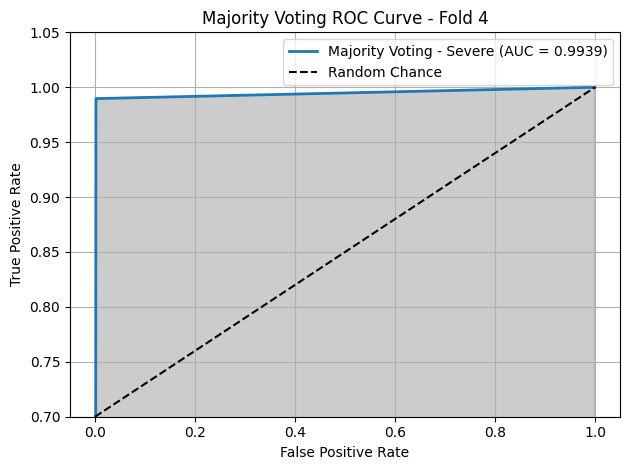

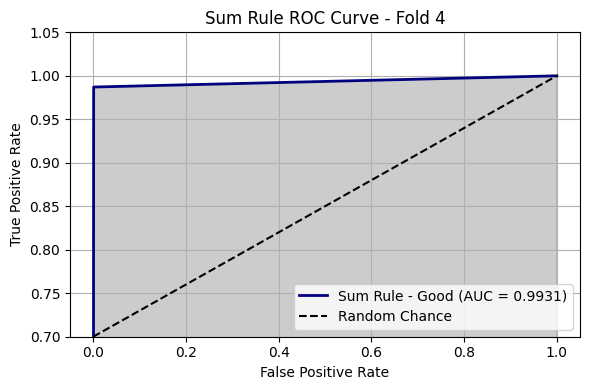

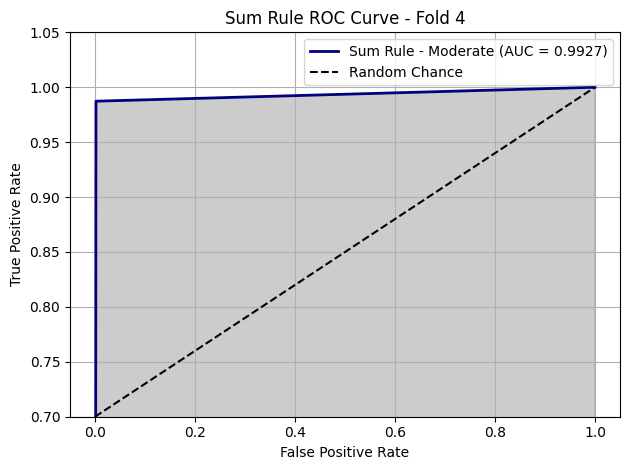

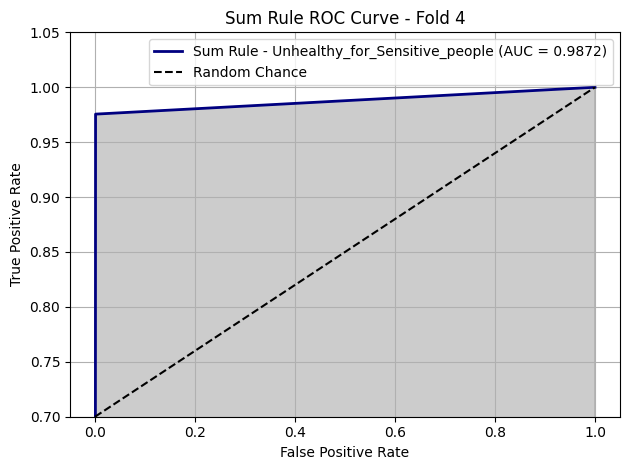

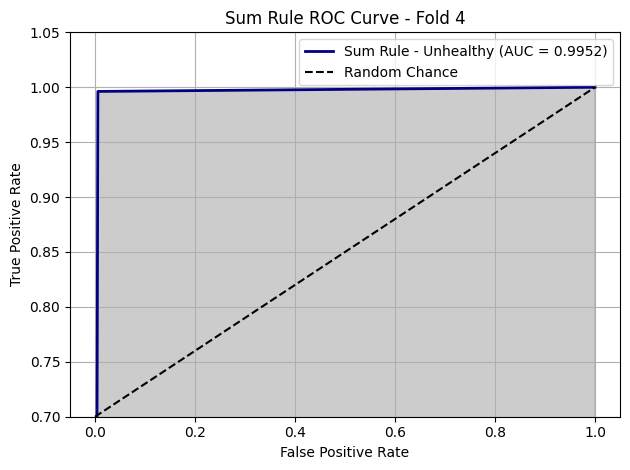

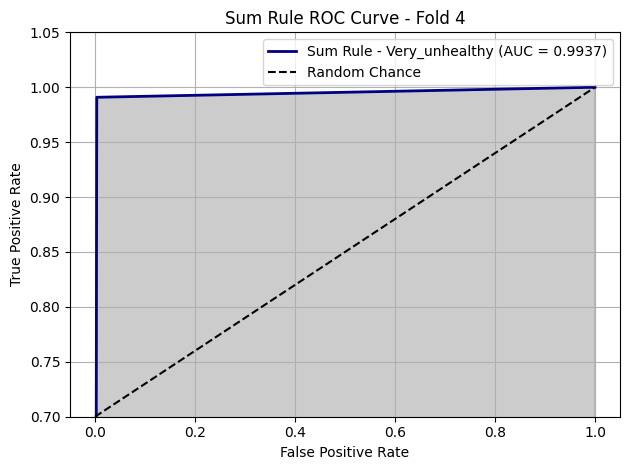

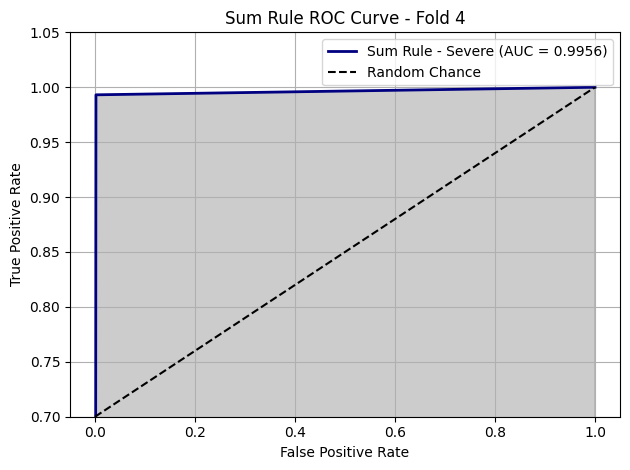

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 59s 181ms/step - accuracy: 0.7034 - f1_score: 0.8564 - loss: 0.7973 - precision: 0.8496 - recall: 0.8708 - val_accuracy: 0.9208 - val_f1_score: 0.8540 - val_loss: 0.2299 - val_precision: 0.8478 - val_recall: 0.8640
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9344 - f1_score: 0.9634 - loss: 0.1897 - precision: 0.9619 - recall: 0.9669 - val_accuracy: 0.9527 - val_f1_score: 0.8650 - val_loss: 0.1560 - val_precision: 0.8630 - val_recall: 0.8688
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9478 - f1_score: 0.9710 - loss: 0.1508 - precision: 0.9707 - recall: 0.9725 - val_accuracy: 0.9559 - val_f1_score: 0.8674 - val_loss: 0.1407 - val_precision: 0.8639 - val_recall: 0.8723
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9736 - f1_score: 0.9852 - loss: 0.0816 - precision: 0.9848 - recall: 0.9861 - val_accuracy: 0.9612 - val_f1_score: 0.8653 - val_loss: 0.1463 - val_precision: 0.8632 -

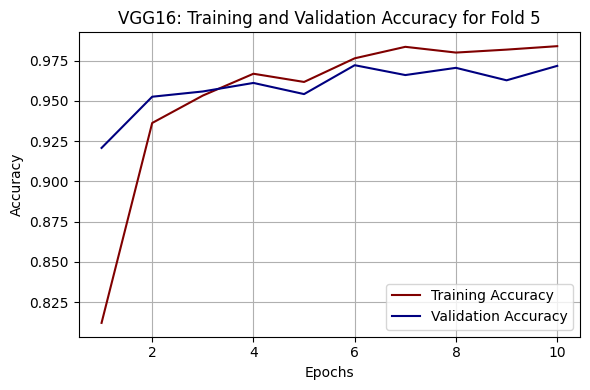

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.7202 - f1_score: 0.8621 - loss: 0.7613 - precision: 0.8577 - recall: 0.8716 - val_accuracy: 0.9290 - val_f1_score: 0.8508 - val_loss: 0.2518 - val_precision: 0.8684 - val_recall: 0.8373
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9288 - f1_score: 0.9606 - loss: 0.2033 - precision: 0.9633 - recall: 0.9598 - val_accuracy: 0.9392 - val_f1_score: 0.8588 - val_loss: 0.1890 - val_precision: 0.8608 - val_recall: 0.8585
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9487 - f1_score: 0.9718 - loss: 0.1518 - precision: 0.9738 - recall: 0.9708 - val_accuracy: 0.9596 - val_f1_score: 0.8654 - val_loss: 0.1544 - val_precision: 0.8696 - val_recall: 0.8630
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9626 - f1_score: 0.9792 - loss: 0.1007 - precision: 0.9787 - recall: 0.9805 - val_accuracy: 0.9522 - val_f1_score: 0.8635 - val_loss: 0.1493 - val_precision: 0.8627 -

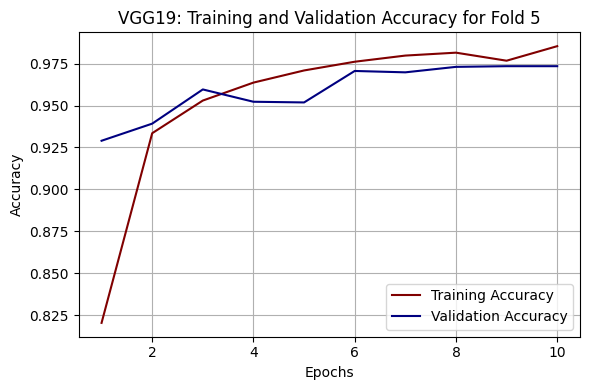

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.7099 - f1_score: 0.8549 - loss: 0.8027 - precision: 0.8554 - recall: 0.8613 - val_accuracy: 0.9282 - val_f1_score: 0.8502 - val_loss: 0.2381 - val_precision: 0.8595 - val_recall: 0.8451
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9400 - f1_score: 0.9666 - loss: 0.1778 - precision: 0.9684 - recall: 0.9662 - val_accuracy: 0.9314 - val_f1_score: 0.8555 - val_loss: 0.2092 - val_precision: 0.8469 - val_recall: 0.8669
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9480 - f1_score: 0.9710 - loss: 0.1470 - precision: 0.9715 - recall: 0.9719 - val_accuracy: 0.9416 - val_f1_score: 0.8591 - val_loss: 0.1729 - val_precision: 0.8540 - val_recall: 0.8674
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9651 - f1_score: 0.9805 - loss: 0.1021 - precision: 0.9794 - recall: 0.9824 - val_accuracy: 0.9588 - val_f1_score: 0.8659 - val_loss: 0.1534 - val_precision: 0.8664 -

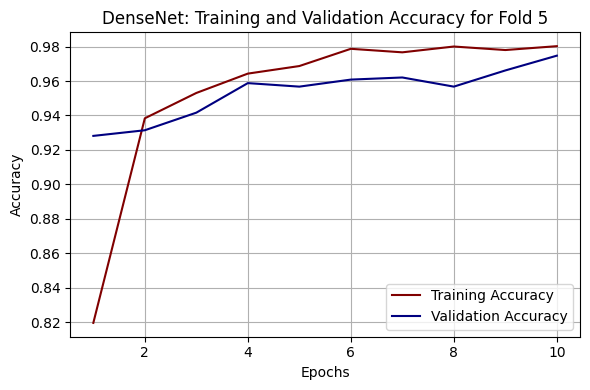

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.7110 - f1_score: 0.8537 - loss: 0.8004 - precision: 0.8542 - recall: 0.8616 - val_accuracy: 0.9412 - val_f1_score: 0.8596 - val_loss: 0.2039 - val_precision: 0.8701 - val_recall: 0.8515
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9312 - f1_score: 0.9618 - loss: 0.2041 - precision: 0.9647 - recall: 0.9603 - val_accuracy: 0.9412 - val_f1_score: 0.8592 - val_loss: 0.1723 - val_precision: 0.8630 - val_recall: 0.8581
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9550 - f1_score: 0.9746 - loss: 0.1302 - precision: 0.9735 - recall: 0.9766 - val_accuracy: 0.9543 - val_f1_score: 0.8639 - val_loss: 0.1504 - val_precision: 0.8731 - val_recall: 0.8566
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step - accuracy: 0.9645 - f1_score: 0.9800 - loss: 0.1010 - precision: 0.9804 - recall: 0.9805 - val_accuracy: 0.9641 - val_f1_score: 0.8678 - val_loss: 0.1424 - val_precision: 0.8630 -

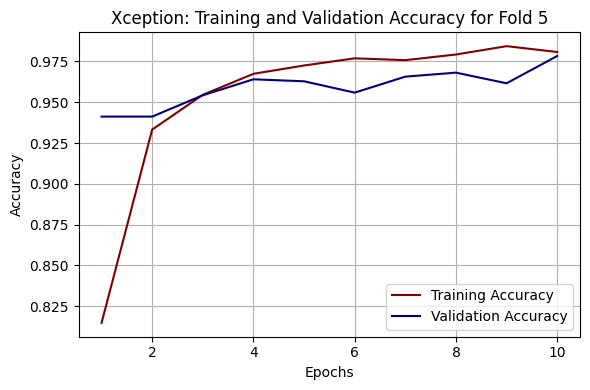


Test Parameter                     Majority Voting          Sum Rule                 Weighted Majority Voting      
--------------------------------------------------------------------------------------------------------------
Accuracy:                          0.9837                   0.9882                   0.9833                        
F1 Score:                          0.9842                   0.9884                   0.9837                        
Precision:                         0.9836                   0.9882                   0.9830                        
Recall:                            0.9850                   0.9886                   0.9845                        




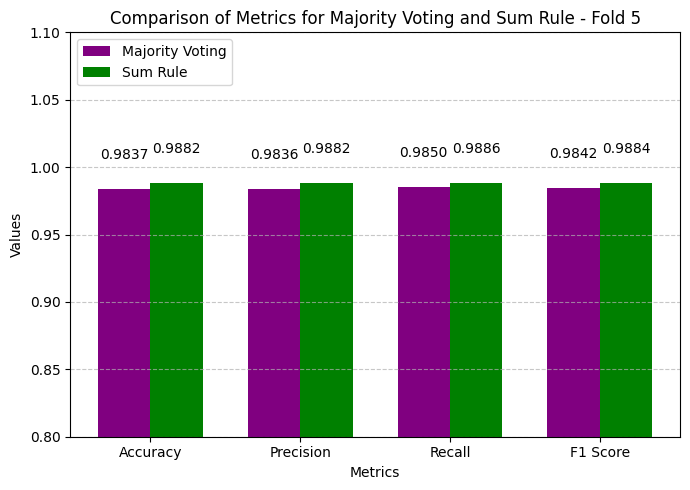

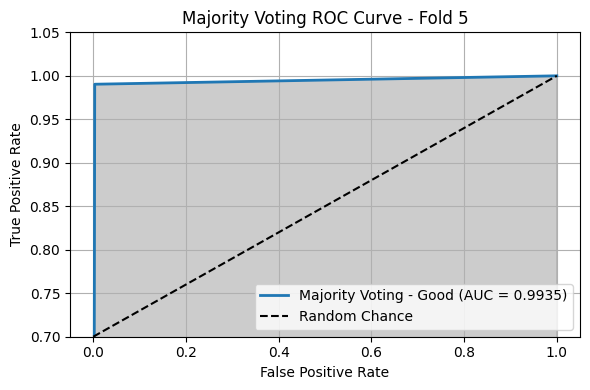

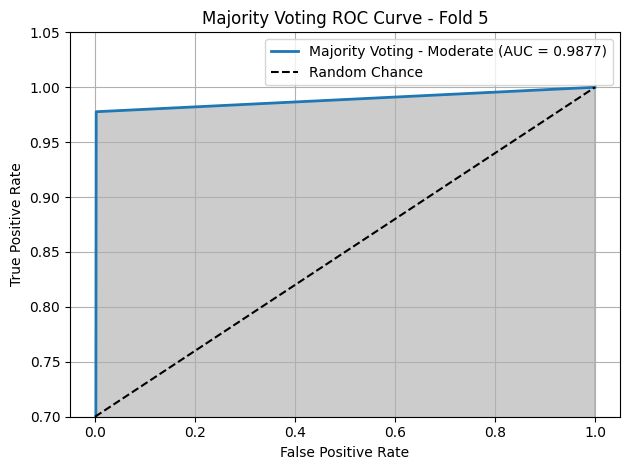

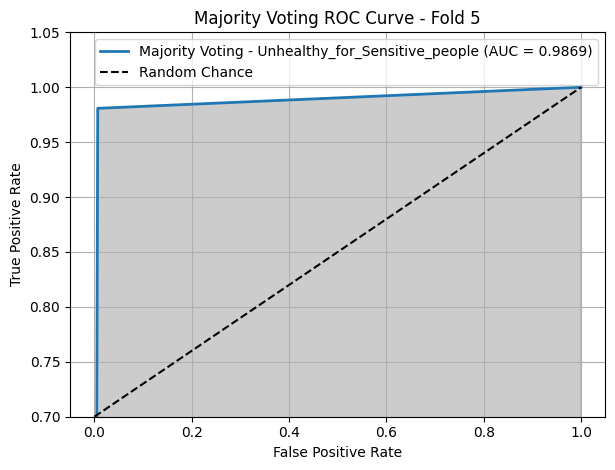

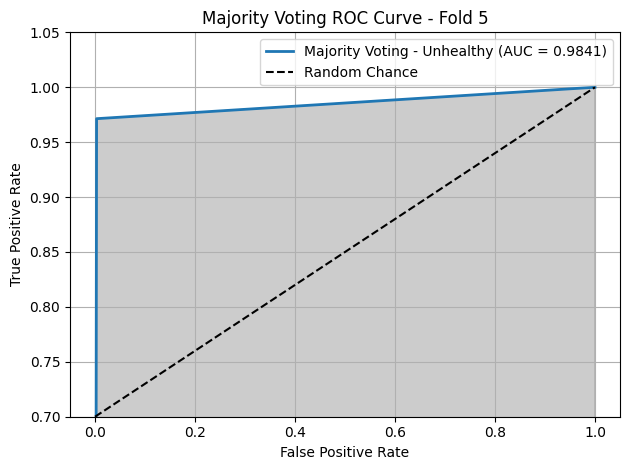

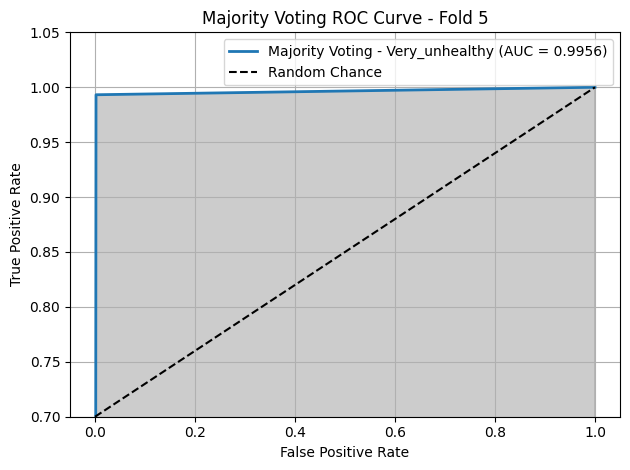

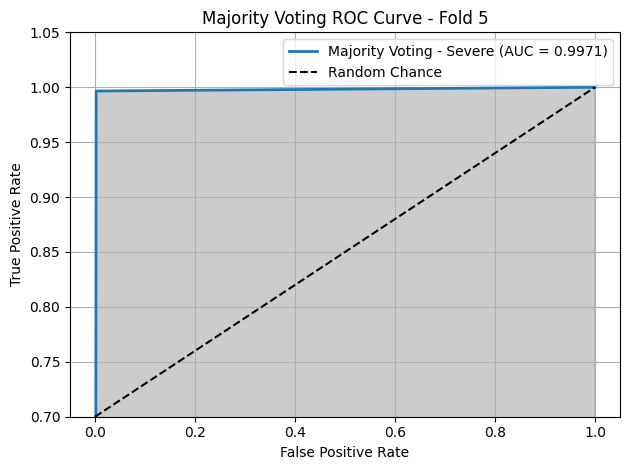

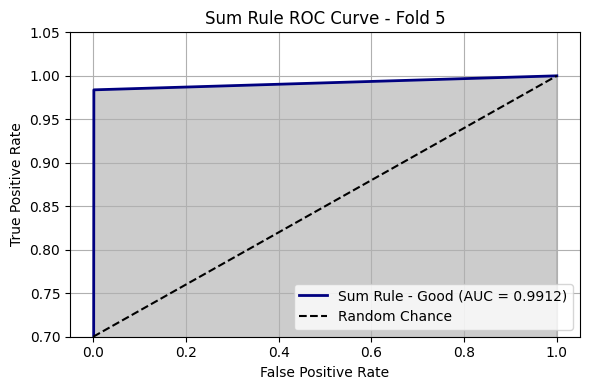

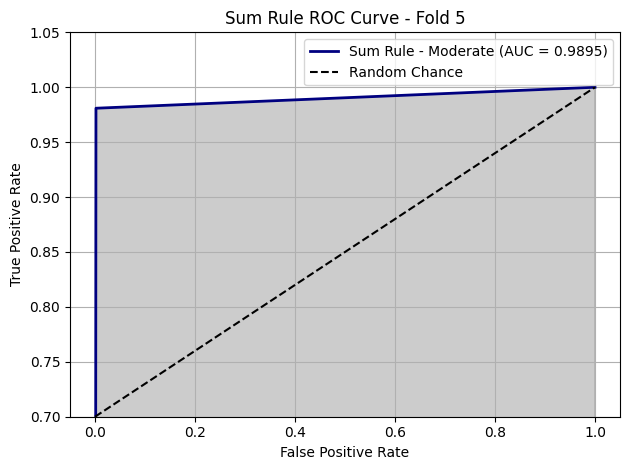

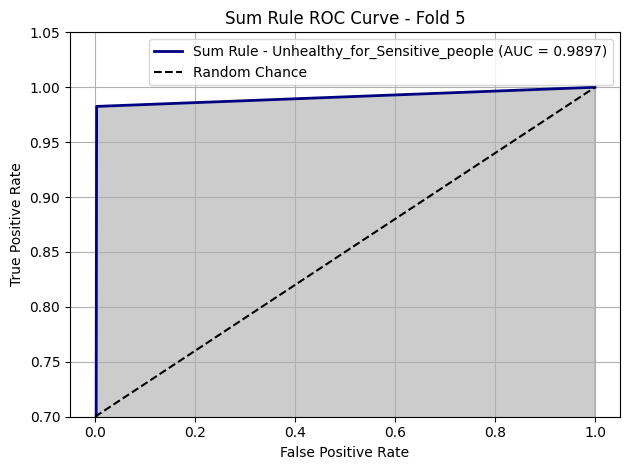

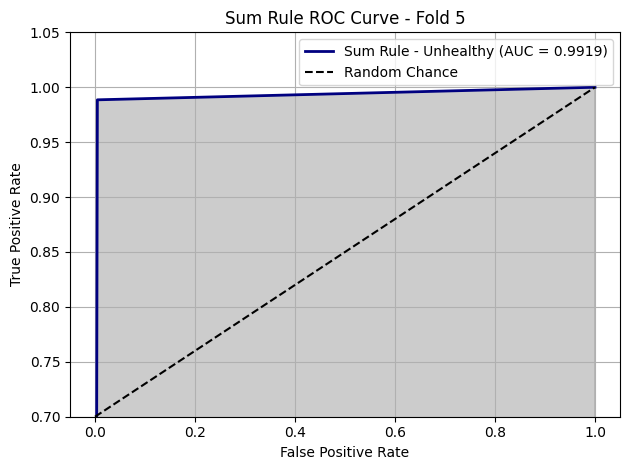

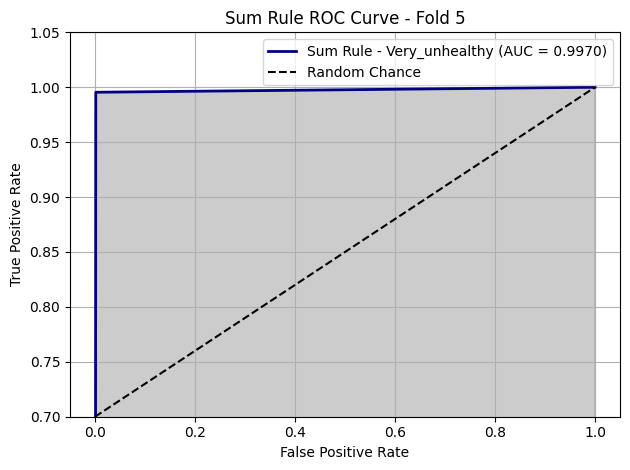

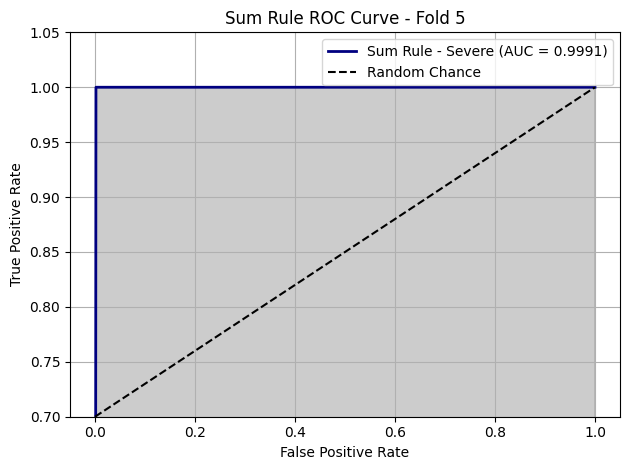

In [25]:
# Initialize storage for ROC data for both methods
majority_tprs = {cls: [] for cls in range(len(class_names))}  # Store interpolated TPRs for majority voting
sumrule_tprs = {cls: [] for cls in range(len(class_names))}   # Store interpolated TPRs for sum rule
majority_aucs = {cls: [] for cls in range(len(class_names))}  # Store AUCs for majority voting
sumrule_aucs = {cls: [] for cls in range(len(class_names))}   # Store AUCs for sum rule
mean_fpr = np.linspace(0, 1, 100)  # Define a common FPR scale



fold_num = 1
    # Define models to be evaluated

# Iterate over each fold
for train_index, test_index in kf.split(X, np.argmax(y_categorical, axis=1)):
#for train_index, test_index in kf.split(X):

    models = {
        "VGG16": create_and_compile_vgg16_model(),
        "VGG19": create_and_compile_vgg19_model(),
        "DenseNet": create_and_compile_densenet_model(),
        "Xception": create_and_compile_xception_model()
        }

    print()
    display(HTML(f'<span style="color:{highlight_color}; background-color:{bg_color}; font-weight: bold;">Fold {fold_num}:</span>'))

    # Split data into training and test sets for the current fold
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]


    # Binarize the true labels
    y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=[0, 1, 2, 3, 4, 5])

    model_predictions = []
    model_probabilities = []


    model_accuracies = {}  # Store accuracy of each model for a given fold
    model_weights = {}  # Store weights assigned to each model

    for model_name, model in models.items():
        print()

        #print(f"  Training {model_name}:")
        display(HTML(f'<span style="color: navy; background-color: lightyellow; font-weight: bold;">  Training {model_name}:</span>'))
        # Train the model
        history = model.fit(X_train, y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test),verbose=1)



        # Accumulate the training and validation accuracies for each fold
        train_accuracies_all_folds[model_name].append(history.history['accuracy'])
        val_accuracies_all_folds[model_name].append(history.history['val_accuracy'])



        # Get predictions and probabilities
        train_predictions = np.argmax(model.predict(X_train), axis=1)
        val_predictions = np.argmax(model.predict(X_test), axis=1)
        probabilities = model.predict(X_test)


        # Evaluate accuracy for the current fold
        #val_accuracy = np.mean(val_predictions == np.argmax(y_test, axis=1))
        #model_accuracies[model_name] = val_accuracy  # Save the accuracy for ranking


        # Get training and validation accuracy
        train_accuracy = np.mean(np.argmax(model.predict(X_train), axis=1) == np.argmax(y_train, axis=1))
        val_accuracy = np.mean(np.argmax(model.predict(X_test), axis=1) == np.argmax(y_test, axis=1))

        model_accuracies[model_name] = val_accuracy  # Save the accuracy for ranking

        # Store the accuracies for averaging
        avg_train_accuracies[model_name].append(train_accuracy)
        avg_val_accuracies[model_name].append(val_accuracy)


        # Store predictions for majority voting and sum rule
        model_predictions.append(val_predictions)
        model_probabilities.append(probabilities)

        # Evaluate on training data and validation data
        train_report = classification_report(np.argmax(y_train, axis=1), train_predictions, output_dict=True,zero_division=1)
        val_report = classification_report(np.argmax(y_test, axis=1), val_predictions, output_dict=True,zero_division=1)


        # Print metrics for training and validation in two columns
        print()
        print(f"{'Parameter':<30}{'Training':<15}{'Validation':<15}")
        print("-" * 55)  # Add a separator line for clarity

        print(f"{'Accuracy ('+model_name+'):':<30}{train_report['accuracy']:<15.4f}{val_report['accuracy']:.4f}")
        print(f"{'F1 Score ('+model_name+'):':<30}{train_report['macro avg']['f1-score']:<15.4f}{val_report['macro avg']['f1-score']:.4f}")
        print(f"{'Precision ('+model_name+'):':<30}{train_report['macro avg']['precision']:<15.4f}{val_report['macro avg']['precision']:.4f}")
        print(f"{'Recall ('+model_name+'):':<30}{train_report['macro avg']['recall']:<15.4f}{val_report['macro avg']['recall']:.4f}")

        print()

############

        """
        class_names = ['Good', 'Moderate', 'U_f_Sensitive_people', 'Unhealthy', 'Very_unhealthy', 'Severe']


        # Get predictions
        val_predictions = np.argmax(model.predict(X_test), axis=1)
        true_labels = np.argmax(y_test, axis=1)

        # Calculate metrics
        true_predictions = np.sum(val_predictions == np.argmax(y_test, axis=1))
        false_predictions = np.sum(val_predictions != np.argmax(y_test, axis=1))
        # Print the total numbers for each fold
        print(f"    Total number of training data: {len(X_train)}")
        print(f"    Total number of predictions: {len(val_predictions)}")
        print(f"    Total number of true predictions: {true_predictions}")
        print(f"    Total number of false predictions: {false_predictions}")
        print()
        """


        """
        # Print false predictions with their true and predicted classes
        false_indices = np.where(val_predictions != true_labels)[0]

        if len(false_indices) > 0:
            print(f"{'True Class':<25}{'Predicted Class':<25}")  # Header for the columns
            print("-" * 50)  # Separator line for clarity

            # Print false predictions with their true and predicted class names in columns
            for idx in false_indices:
                true_class_name = class_names[true_labels[idx]]
                predicted_class_name = class_names[val_predictions[idx]]
                print(f"{true_class_name:<25}{predicted_class_name:<25}")

        print()
        """


    ###################

        # Plot training and validation accuracy
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'maroon', label='Training Accuracy')
        plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'navy', label='Validation Accuracy')
        plt.title(f'{model_name}: Training and Validation Accuracy for Fold {fold_num}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        #plt.ylim(0.5, 1)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        print()

        """
        # Plot the ROC curve for each class
        plt.figure(figsize=(6, 4))

        # Loop over each class to plot individual AUC/ROC
        for i in range(len(class_names)):
            # Compute ROC curve and AUC for each class (One-vs-Rest)
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve for the current class
            plt.plot(fpr, tpr, lw=2, color = 'navy', label=f'{class_names[i]} (AUC = {roc_auc:.4f})')
            #to print shadow
            plt.fill_between(fpr, tpr, alpha=0.4, color = 'grey')
            # Plot diagonal line (no skill line)
            plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

            # Customize plot
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curves for {model_name} - Fold {fold_num}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            print()

            """



        # Store metrics for averaging later
        fold_train_metrics[model_name].append(train_report['accuracy'])
        fold_val_metrics[model_name].append(val_report['accuracy'])

        fold_train_precision[model_name].append(train_report['macro avg']['precision'])
        fold_val_precision[model_name].append(val_report['macro avg']['precision'])
        fold_train_recall[model_name].append(train_report['macro avg']['recall'])
        fold_val_recall[model_name].append(val_report['macro avg']['recall'])
        fold_train_f1[model_name].append(train_report['macro avg']['f1-score'])
        fold_val_f1[model_name].append(val_report['macro avg']['f1-score'])


        # Convert model_predictions to a numpy array and perform majority voting
    model_predictions = np.array(model_predictions)
    majority_votes = mode(model_predictions, axis=0)[0].flatten()

    #model_probabilities = np.array(model_probabilities)
    #sumrule_votes = mode(model_probabilities axis=0)[0].flatten()

    # Calculate majority voting accuracy
    majority_report = classification_report(np.argmax(y_test, axis=1), majority_votes, output_dict=True, zero_division=1) #Test metrics



#######

    # Store the majority voting metrics
    fold_majority_voting_precision.append(majority_report['macro avg']['precision'])
    fold_majority_voting_recall.append(majority_report['macro avg']['recall'])
    fold_majority_voting_f1.append(majority_report['macro avg']['f1-score'])




    # Sum rule: sum the probabilities across models and take the class with highest summed probability
    model_probabilities = np.array(model_probabilities)
    summed_probabilities = np.sum(model_probabilities, axis=0)
    sum_rule_predictions = np.argmax(summed_probabilities, axis=1)

   # Calculate sum rule accuracy
    sum_rule_report = classification_report(np.argmax(y_test, axis=1), sum_rule_predictions, output_dict=True, zero_division=1) #Test Metrics

    # Store the sum rule metrics
    fold_sum_rule_precision.append(sum_rule_report['macro avg']['precision'])
    fold_sum_rule_recall.append(sum_rule_report['macro avg']['recall'])
    fold_sum_rule_f1.append(sum_rule_report['macro avg']['f1-score'])

    majority_voting_accuracy = np.mean(majority_votes == np.argmax(y_test, axis=1))   #Testing metrics
    sum_rule_accuracy = np.mean(sum_rule_predictions == np.argmax(y_test, axis=1))



    """
    print()
    print(f"After completion of Fold {fold_num}, the result of ensemble validation is:")
    print()
    print(f"{'Test Parameter':<35}{'Majority Voting':<25}{'Sum Rule':<15}")
    print("-" * 55)  # Separator line for clarity

    # Print majority and sum rule voting metrics
    print(f"{'Accuracy:':<35}{majority_voting_accuracy:<25.4f}{sum_rule_accuracy:.4f}")
    print(f"{'F1 Score:':<35}{majority_report['macro avg']['f1-score']:<25.4f}{sum_rule_report['macro avg']['f1-score']:.4f}")
    print(f"{'Precision:':<35}{majority_report['macro avg']['precision']:<25.4f}{sum_rule_report['macro avg']['precision']:.4f}")
    print(f"{'Recall:':<35}{majority_report['macro avg']['recall']:<25.4f}{sum_rule_report['macro avg']['recall']:.4f}")
    print()

    """



     # Rank models based on accuracy (higher accuracy gets higher weight)
    ranked_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

    # Assign customizable weights based on rank
    total_models = len(models)
    weights = {}
    # Define the custom weights you want to assign
    custom_weights = [0.3, 0.3, 0.2, 0.2]

    # Assuming 'ranked_models' is already sorted by accuracy and contains the model names
    for rank, (model_name, accuracy) in enumerate(ranked_models, 1):
        # Assign the custom weight based on the rank
        weights[model_name] = custom_weights[rank - 1]  # rank-1 for 0-based index in custom_weights

    """
    # Print the weights assigned to each model
    print(f"  Weights for Weighted Majority Voting (Fold {fold_num}):")
    for model, weight in weights.items():
        print(f"    {model}: {weight:.4f}")
    print()
    """



    # Perform Weighted Majority Voting: Each model votes with its weight
    weighted_predictions = np.zeros((len(X_test), num_classes))  # Updated: num_classes, not len(models)

    for idx, model_name in enumerate(models):
        model_pred = model_predictions[idx]  # List of class predictions for the model (e.g., 0, 1, 2)
        for i in range(len(model_pred)):
            # We will add the weighted contribution of each model to the corresponding predicted class
            predicted_class = model_pred[i]  # Updated: Direct class predictions
            weighted_predictions[i, predicted_class] += weights[model_name]  # Add model weight directly

    # The final prediction for each sample is the class with the highest summed weight
    weighted_majority_predictions = np.argmax(weighted_predictions, axis=1)

    # Evaluate weighted majority voting accuracy
    weighted_majority_accuracy = np.mean(weighted_majority_predictions == np.argmax(y_test, axis=1))  # Assuming y_test is one-hot encoded

    # Calculate classification metrics for weighted majority voting
    weighted_majority_report = classification_report(np.argmax(y_test, axis=1), weighted_majority_predictions, output_dict=True, zero_division=1)


    # Store the metrics
    weighted_majority_voting_precision.append(weighted_majority_report['macro avg']['precision'])
    weighted_majority_voting_recall.append(weighted_majority_report['macro avg']['recall'])
    weighted_majority_voting_f1.append(weighted_majority_report['macro avg']['f1-score'])



    print()
    display(HTML(f'<span style="color: white; background-color: darkgreen; font-size: 16px; font-weight: bold; padding: 5px;">After completion of Fold {fold_num}, the result of ensemble validation is:</span>'))
    print()

    # Header for the table
    print(f"{'Test Parameter':<35}{'Majority Voting':<25}{'Sum Rule':<25}{'Weighted Majority Voting':<30}")
    print("-" * 110)  # Separator line for clarity

    # Print metrics for all methods
    print(f"{'Accuracy:':<35}{majority_voting_accuracy:<25.4f}{sum_rule_accuracy:<25.4f}{weighted_majority_report['accuracy']:<30.4f}")
    print(f"{'F1 Score:':<35}{majority_report['macro avg']['f1-score']:<25.4f}{sum_rule_report['macro avg']['f1-score']:<25.4f}{weighted_majority_report['macro avg']['f1-score']:<30.4f}")
    print(f"{'Precision:':<35}{majority_report['macro avg']['precision']:<25.4f}{sum_rule_report['macro avg']['precision']:<25.4f}{weighted_majority_report['macro avg']['precision']:<30.4f}")
    print(f"{'Recall:':<35}{majority_report['macro avg']['recall']:<25.4f}{sum_rule_report['macro avg']['recall']:<25.4f}{weighted_majority_report['macro avg']['recall']:<30.4f}")
    print()




    """
    # For Majority Voting - One-vs-Rest
    plt.figure(figsize=(6, 4))
    for i in range(len(class_names)):
        # Compute ROC curve for each class (One-vs-Rest)
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], majority_votes[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, color = 'indigo', label=f'{class_names[i]} (AUC = {roc_auc:.4f})')
        # Plot diagonal line (no skill line)
        plt.fill_between(fpr, tpr, alpha=0.4, color = 'grey')
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'AUC/ROC Curves for Majority Voting (Fold {fold_num})')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # For Sum Rule - One-vs-Rest
    plt.figure(figsize=(6, 4))
    for i in range(len(class_names)):
        # Compute ROC curve for each class (One-vs-Rest)
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], summed_probabilities[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, color = 'crimson', label=f'{class_names[i]} (AUC = {roc_auc:.4f})')
        plt.fill_between(fpr, tpr, alpha=0.4, color = 'grey')
        # Plot diagonal line (no skill line)
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'AUC/ROC Curves for Sum Rule (Fold {fold_num})')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        """

    #################### Bar diagram plot #########
    # Metrics for Majority Voting and Sum Rule
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Collect the metrics
    majority_voting_metrics = [
        majority_voting_accuracy,
        majority_report['macro avg']['precision'],
        majority_report['macro avg']['recall'],
        majority_report['macro avg']['f1-score']
    ]

    sum_rule_metrics = [
        sum_rule_accuracy,
        sum_rule_report['macro avg']['precision'],
        sum_rule_report['macro avg']['recall'],
        sum_rule_report['macro avg']['f1-score']
    ]

    # Create bar plot
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars
    print()
    plt.figure(figsize=(7, 5))

    # Bar chart for Majority Voting (purple bars)
    bar1 = plt.bar(x - width / 2, majority_voting_metrics, width, label='Majority Voting', color='purple')

    # Bar chart for Sum Rule (green bars)
    bar2 = plt.bar(x + width / 2, sum_rule_metrics, width, label='Sum Rule', color='green')


    # Customize the chart
    plt.xlabel("Metrics")
    plt.ylabel("Values")
    plt.title(f"Comparison of Metrics for Majority Voting and Sum Rule - Fold {fold_num}")
    plt.xticks(x, metrics)
    plt.ylim(0.8, 1.1)  # Adjust y-axis to fit all values comfortably
    plt.legend(loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Add values on top of the bars
    def add_values_to_bars(bars):
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom')

    add_values_to_bars(bar1)
    add_values_to_bars(bar2)

    # Show the plot
    plt.tight_layout()
    plt.show()
    print()

    # Plot the AUC/ROC curve for majority voting and sum rule using One-vs-Rest method for each class

    class_names = ['Good', 'Moderate', 'Unhealthy_for_Sensitive_people', 'Unhealthy', 'Very_unhealthy', 'Severe']


    # Plot ROC for Majority Voting
    plt.figure(figsize=(6, 4))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], majority_votes == i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Majority Voting - {class_names[i]} (AUC = {roc_auc:.4f})')
        plt.fill_between(fpr, tpr, alpha=0.4, color = 'grey')
        plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = "Random Chance")
        plt.title(f'Majority Voting ROC Curve - Fold {fold_num}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="best")
        plt.ylim(0.7, 1.05)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        print()


    # Plot ROC for Sum Rule
    plt.figure(figsize=(6, 4))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], sum_rule_predictions == i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color = 'navy', label=f'Sum Rule - {class_names[i]} (AUC = {roc_auc:.4f})')
        plt.fill_between(fpr, tpr, alpha=0.4, color = 'grey')
        plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = "Random Chance")
        plt.title(f'Sum Rule ROC Curve - Fold {fold_num}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="best")
        plt.ylim(0.7, 1.05)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        print()




    for i in range(len(class_names)):
        # Compute ROC for Majority Voting
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], majority_votes == i)
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)  # Interpolate TPRs
        interp_tpr[0] = 0.0  # Ensure TPR starts at 0
        majority_tprs[i].append(interp_tpr)
        majority_aucs[i].append(roc_auc)

        # Compute ROC for Sum Rule
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], sum_rule_predictions == i)
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)  # Interpolate TPRs
        interp_tpr[0] = 0.0  # Ensure TPR starts at 0
        sumrule_tprs[i].append(interp_tpr)
        sumrule_aucs[i].append(roc_auc)



    ###################

    # Append accuracies to the fold_accuracies dictionary
    fold_accuracies["MajorityVoting"].append(majority_voting_accuracy)
    fold_accuracies["SumRule"].append(sum_rule_accuracy)
    print()

    fold_num += 1


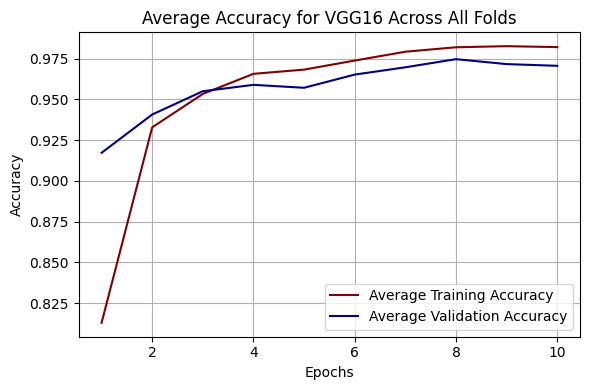

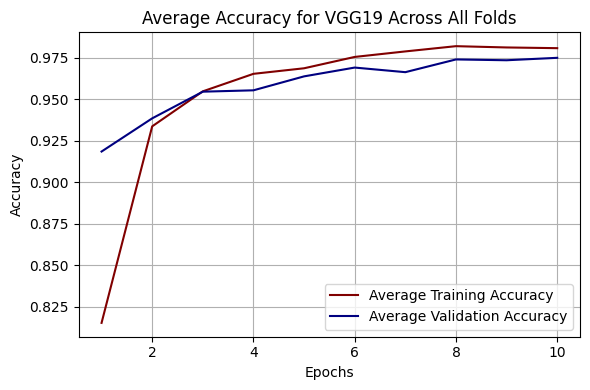

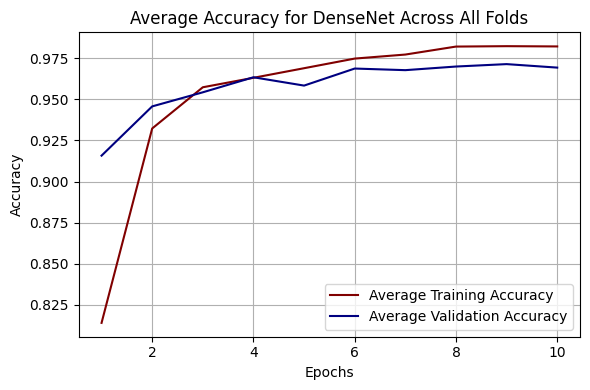

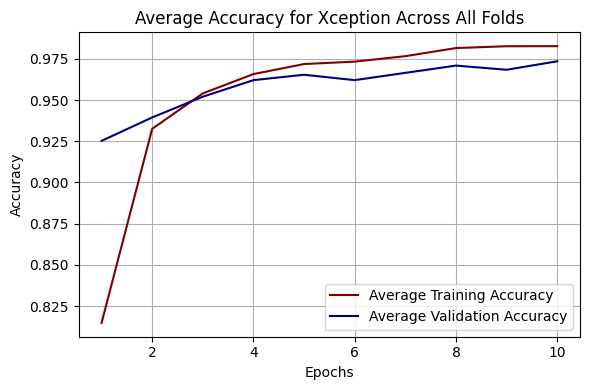

In [26]:
# After all folds, compute the average accuracy for each model
# Average the accuracies across folds (mean across all folds for each epoch)
avg_train_accuracies = {model_name: np.mean(np.array(train_accuracies_all_folds[model_name]), axis=0) for model_name in models.keys()}
avg_val_accuracies = {model_name: np.mean(np.array(val_accuracies_all_folds[model_name]), axis=0) for model_name in models.keys()}

# Plot the average accuracies across all folds for each model
for model_name in models.keys():
    plt.figure(figsize=(6, 4))

    # Plot average training and validation accuracy
    plt.plot(range(1, len(avg_train_accuracies[model_name]) + 1), avg_train_accuracies[model_name], 'maroon', label='Average Training Accuracy')
    plt.plot(range(1, len(avg_val_accuracies[model_name]) + 1), avg_val_accuracies[model_name], 'navy', label='Average Validation Accuracy')

    # Customize plot
    plt.title(f"Average Accuracy for {model_name} Across All Folds")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    #plt.ylim(0.7, 1.05)
    plt.tight_layout()
    plt.show()
    print()

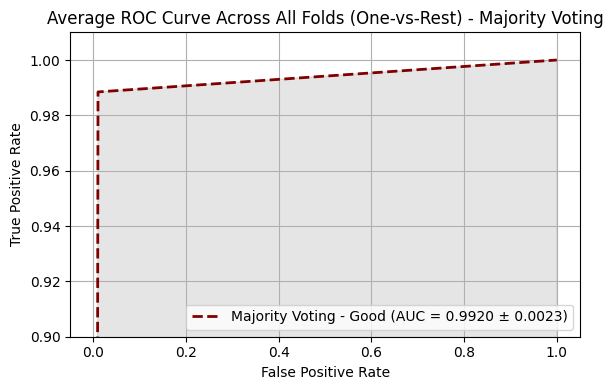

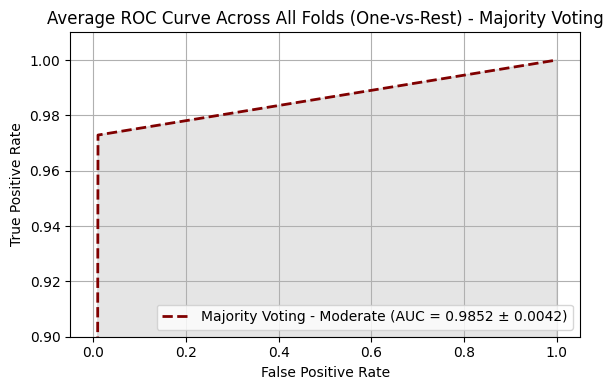

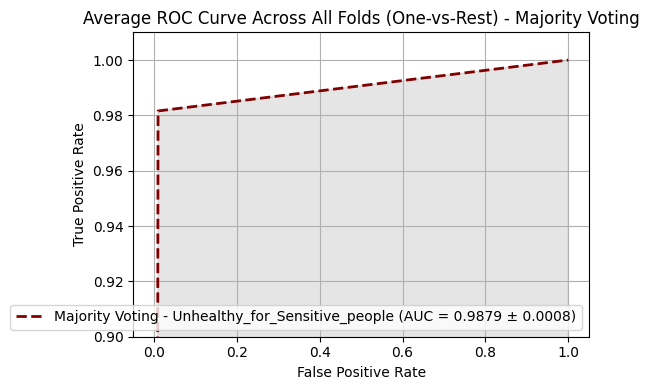

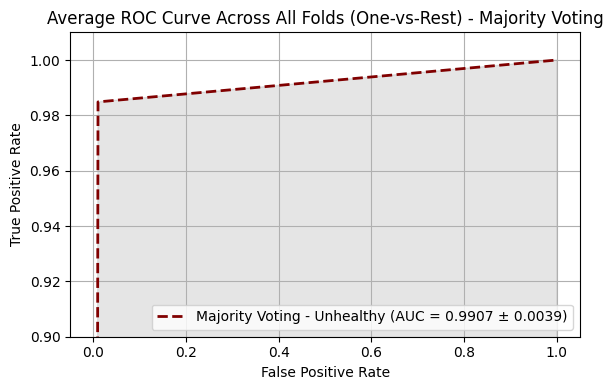

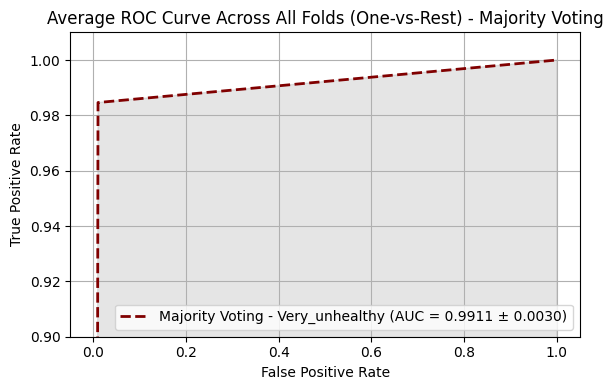

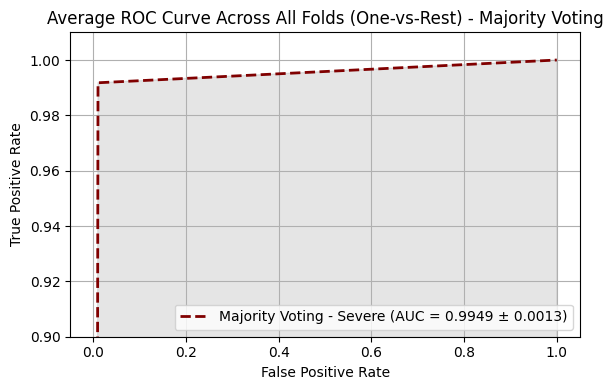

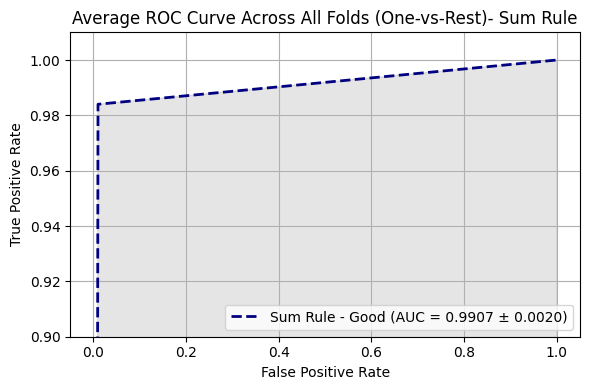

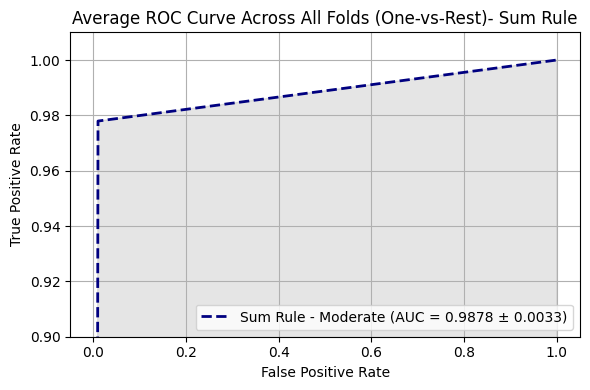

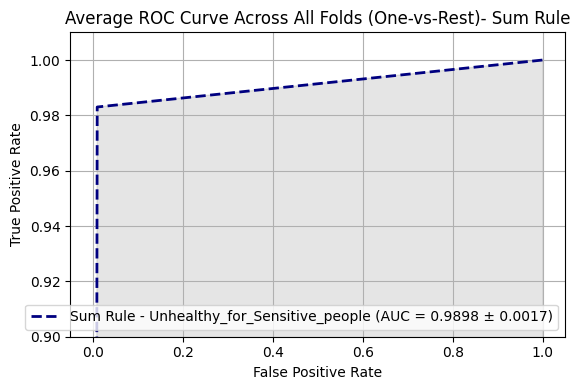

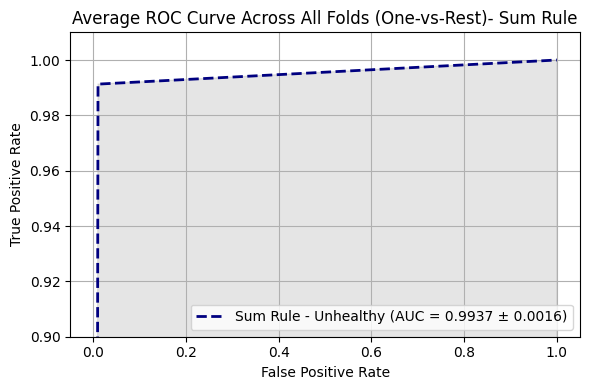

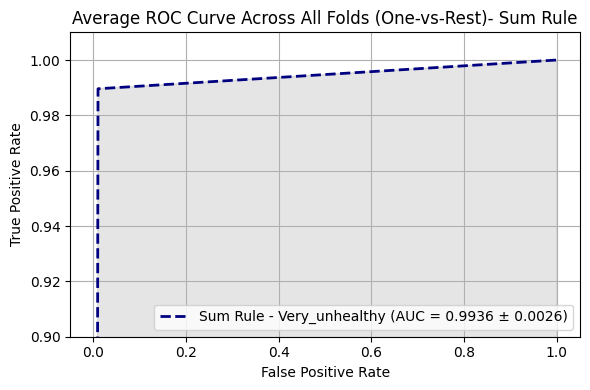

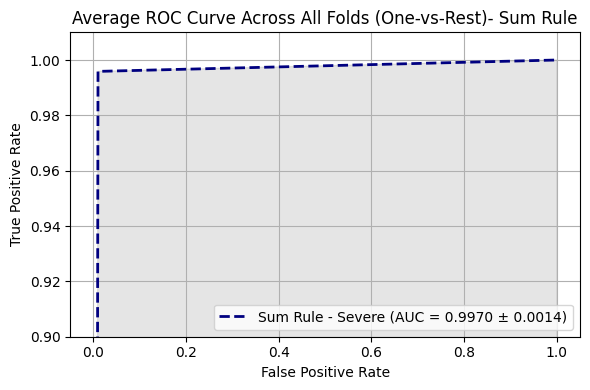

In [42]:
# After all folds, compute average ROC and AUC for each method and class

for i in range(len(class_names)):
    plt.figure(figsize=(6, 4))
    # Majority Voting
    mean_tpr_majority = np.mean(majority_tprs[i], axis=0)
    mean_tpr_majority[-1] = 1.0  # Ensure TPR ends at 1
    std_tpr_majority = np.std(majority_tprs[i], axis=0)
    mean_auc_majority = np.mean(majority_aucs[i])
    std_auc_majority = np.std(majority_aucs[i])

    plt.plot(mean_fpr, mean_tpr_majority,linestyle='--',color='maroon', lw=2, label=f"Majority Voting - {class_names[i]} (AUC = {mean_auc_majority:.4f} ± {std_auc_majority:.4f})")
    plt.fill_between(mean_fpr, mean_tpr_majority , alpha=0.2, color = 'grey')
    # Plot random chance line
    #plt.plot([0, 1], [0.7, 1], color='black', linestyle='--', lw=1.5, label="Random Chance")

    # Add labels, legend, and grid
    plt.title("Average ROC Curve Across All Folds (One-vs-Rest) - Majority Voting")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.ylim(0.9, 1.01)
    plt.tight_layout()
    plt.show()
    print()


for i in range(len(class_names)):
    plt.figure(figsize=(6, 4))
    # Sum Rule
    mean_tpr_sumrule = np.mean(sumrule_tprs[i], axis=0)
    mean_tpr_sumrule[-1] = 1.0  # Ensure TPR ends at 1
    std_tpr_sumrule = np.std(sumrule_tprs[i], axis=0)
    mean_auc_sumrule = np.mean(sumrule_aucs[i])
    std_auc_sumrule = np.std(sumrule_aucs[i])

    plt.plot(mean_fpr, mean_tpr_sumrule, linestyle='--',color='navy', lw=2, label=f"Sum Rule - {class_names[i]} (AUC = {mean_auc_sumrule:.4f} ± {std_auc_sumrule:.4f})")
    plt.fill_between(mean_fpr, mean_tpr_sumrule, alpha=0.2, color='grey')

    # Plot random chance line
    #plt.plot([0, 1], [0.7, 1], color='black', linestyle='--', lw=1.5, label="Random Chance")
    # Add labels, legend, and grid
    plt.title("Average ROC Curve Across All Folds (One-vs-Rest)- Sum Rule")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.ylim(0.9, 1.01)
    plt.tight_layout()
    plt.show()
    print()


Fold Number                        Training       Validation     
-------------------------------------------------------
1                                  0.9904         0.9694         
2                                  0.9905         0.9710         
3                                  0.9894         0.9702         
4                                  0.9841         0.9706         
5                                  0.9906         0.9718         



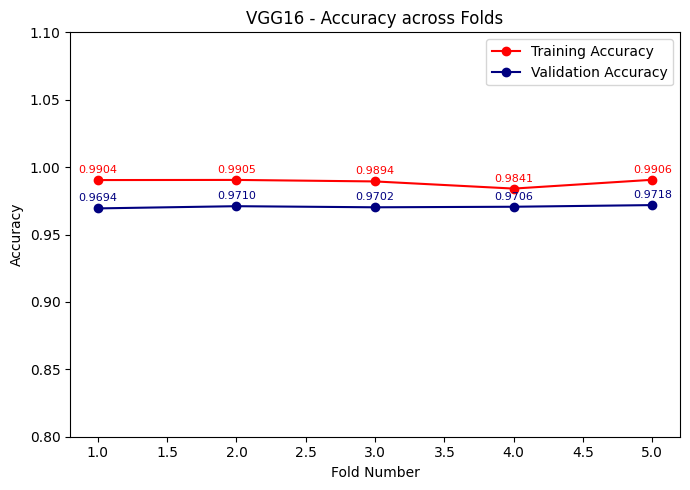


Fold Number                        Training       Validation     
-------------------------------------------------------
1                                  0.9934         0.9747         
2                                  0.9931         0.9755         
3                                  0.9945         0.9796         
4                                  0.9906         0.9714         
5                                  0.9899         0.9735         



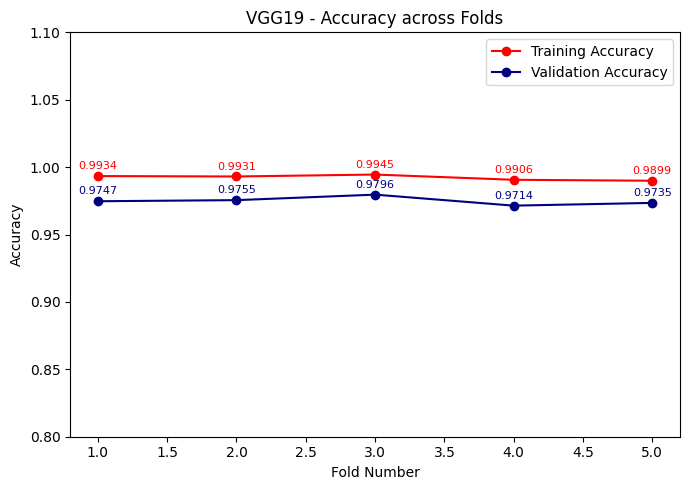


Fold Number                        Training       Validation     
-------------------------------------------------------
1                                  0.9874         0.9616         
2                                  0.9957         0.9747         
3                                  0.9781         0.9571         
4                                  0.9944         0.9784         
5                                  0.9945         0.9747         



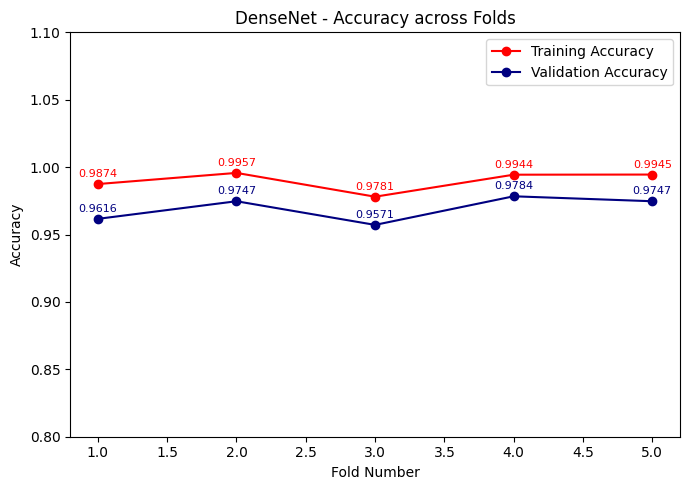


Fold Number                        Training       Validation     
-------------------------------------------------------
1                                  0.9934         0.9763         
2                                  0.9910         0.9722         
3                                  0.9886         0.9678         
4                                  0.9907         0.9727         
5                                  0.9920         0.9784         



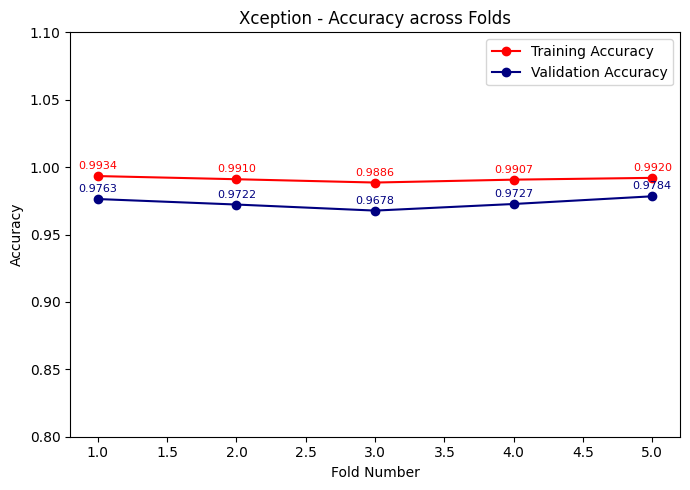

In [45]:
# Define the models you want to plot
model_names = ['VGG16', 'VGG19', 'DenseNet', 'Xception']

# Calculate average metrics across folds
print()
display(HTML(f'<span style="color: white; background-color: darkblue; font-size: 15px; font-weight: bold; padding: 5px;">Accuracies across folds:</span>'))
print()

# Loop through each model and create a line plot for training and validation accuracy
for model_name in models.keys():
    # Collect the training and validation accuracy values for each fold
    train_accuracies = fold_train_metrics[model_name]
    val_accuracies = fold_val_metrics[model_name]

    # Print the metrics as before
    #print(f"\n{model_name}:")
    display(HTML(f'<span style="color: yellow; background-color: darkgreen; font-size: 15px; font-weight: bold; padding: 5px;">{model_name}:</span>'))
    print()
    print(f"{'Fold Number':<35}{'Training':<15}{'Validation':<15}")
    print("-" * 55)

    for fold_num in range(len(train_accuracies)):
        print(f"{fold_num+1:<35}{train_accuracies[fold_num]:<15.4f}{val_accuracies[fold_num]:<15.4f}")
        #print(f"{'Training Accuracy ('+model_name+'):':<35}{train_accuracies[fold_num]:<15.4f}")
        #print(f"{'Validation Accuracy ('+model_name+'):':<35}{val_accuracies[fold_num]:<15.4f}")
    print()

    # Create a line plot for the current model for Training and Validation Accuracy across folds
    fig, ax = plt.subplots(figsize=(7, 5))

    # Plot training and validation accuracy as lines
    ax.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='red')
    ax.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='navy')

        # Annotate each point with its value
    for i, value in enumerate(train_accuracies):
        ax.annotate(f'{value:.4f}', (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')
    for i, value in enumerate(val_accuracies):
        ax.annotate(f'{value:.4f}', (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='navy')


    # Add labels, title, and legend
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{model_name} - Accuracy across Folds')
    ax.legend()

    # Set the y-axis limits from 0.5 to 1.1
    ax.set_ylim(0.8, 1.1)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [29]:
# Print all parameters for all folds and all algorithms grouped by fold
#print("\nParameters Across Folds and Algorithms:")
print()
display(HTML(f'<span style="color: red; background-color: skyblue; font-size: 16px; font-weight: bold; padding: 5px;">Parameters Across Folds and Algorithms:</span>'))
print()

# Define headers for the table
headers = ["Fold", "Algorithm", "Training Accuracy", "Validation Accuracy"]

# Print the headers
print(f"{headers[0]:<10}{headers[1]:<15}{headers[2]:<20}{headers[3]:<20}")
print("-" * 70)

# Get the number of folds from any model's metrics
num_folds = len(next(iter(fold_train_metrics.values())))

# Loop through folds first, then iterate over algorithms for each fold
for fold_num in range(1, num_folds + 1):
    print(f"Fold {fold_num:<6}")  # Print fold header
    for model_name in models.keys():
        # Fetch the corresponding training and validation accuracy for the current fold
        train_accuracy = fold_train_metrics[model_name][fold_num - 1]
        val_accuracy = fold_val_metrics[model_name][fold_num - 1]
        # Print the metrics for the current model and fold
        print(f"{'':<10}{model_name:<15}{train_accuracy:<20.4f}{val_accuracy:<20.4f}")
    print("-" * 70)  # Add a separator after each fold


Fold      Algorithm      Training Accuracy   Validation Accuracy 
----------------------------------------------------------------------
Fold 1     
          VGG16          0.9904              0.9694              
          VGG19          0.9934              0.9747              
          DenseNet       0.9874              0.9616              
          Xception       0.9934              0.9763              
----------------------------------------------------------------------
Fold 2     
          VGG16          0.9905              0.9710              
          VGG19          0.9931              0.9755              
          DenseNet       0.9957              0.9747              
          Xception       0.9910              0.9722              
----------------------------------------------------------------------
Fold 3     
          VGG16          0.9894              0.9702              
          VGG19          0.9945              0.9796              
          DenseNet      

In [30]:
# Print all parameters for all folds and all algorithms grouped by fold
#print("\nParameters Across Folds and Algorithms:")
print()
display(HTML(f'<span style="color: darkred; background-color: orange; font-size: 16px; font-weight: bold; padding: 5px;">Parameters Across Folds and Algorithms:</span>'))
print()

# Define headers for the table
headers = [
    "Fold", "Algorithm", "Train_Acc", "Val_Acc",
    "Train_F1", "Val_F1", "Train_Prec",
    "Val_Prec", "Train _Recall", "Val_Recall"
]

# Print the headers
print(f"{headers[0]:<10}{headers[1]:<15}{headers[2]:<15}{headers[3]:<15}{headers[4]:<15}{headers[5]:<15}{headers[6]:<15}{headers[7]:<15}{headers[8]:<15}{headers[9]:<15}")
print("-" * 140)

# Get the number of folds from any model's metrics
num_folds = len(next(iter(fold_train_metrics.values())))

# Loop through folds first, then iterate over algorithms for each fold
for fold_num in range(1, num_folds + 1):
    print(f"Fold {fold_num:<6}")  # Print fold header
    for model_name in models.keys():
        # Fetch the corresponding training and validation metrics for the current fold
        train_accuracy = fold_train_metrics[model_name][fold_num - 1]
        val_accuracy = fold_val_metrics[model_name][fold_num - 1]

        # Fetch the corresponding F1 score, precision, and recall for train and validation
        train_f1 = fold_train_f1[model_name][fold_num - 1]
        val_f1 = fold_val_f1[model_name][fold_num - 1]
        train_precision = fold_train_precision[model_name][fold_num - 1]
        val_precision = fold_val_precision[model_name][fold_num - 1]
        train_recall = fold_train_recall[model_name][fold_num - 1]
        val_recall = fold_val_recall[model_name][fold_num - 1]

        # Print the metrics for the current model and fold
        print(f"{'':<10}{model_name:<15}{train_accuracy:<15.4f}{val_accuracy:<15.4f}{train_f1:<15.4f}{val_f1:<15.4f}{train_precision:<15.4f}{val_precision:<15.4f}{train_recall:<15.4f}{val_recall:<15.4f}")
    print("-" * 140)  # Add a separator after each fold


Fold      Algorithm      Train_Acc      Val_Acc        Train_F1       Val_F1         Train_Prec     Val_Prec       Train _Recall  Val_Recall     
--------------------------------------------------------------------------------------------------------------------------------------------
Fold 1     
          VGG16          0.9904         0.9694         0.9908         0.9693         0.9911         0.9708         0.9906         0.9680         
          VGG19          0.9934         0.9747         0.9940         0.9748         0.9935         0.9732         0.9945         0.9768         
          DenseNet       0.9874         0.9616         0.9873         0.9604         0.9858         0.9579         0.9888         0.9632         
          Xception       0.9934         0.9763         0.9937         0.9765         0.9944         0.9782         0.9931         0.9751         
--------------------------------------------------------------------------------------------------------------------


Model Name     Train_Acc      Val_Acc        Train_F1       Val_F1         Train_Precision     Val_Precision  Train_Recall   Val_Recall     
---------------------------------------------------------------------------------------------------------------------------------------
VGG16          0.9890         0.9706         0.9885         0.9699         0.9885              0.9702         0.9887         0.9703         
VGG19          0.9923         0.9749         0.9921         0.9746         0.9920              0.9740         0.9922         0.9755         
DenseNet       0.9900         0.9693         0.9902         0.9691         0.9906              0.9701         0.9898         0.9685         
Xception       0.9911         0.9735         0.9906         0.9725         0.9908              0.9726         0.9904         0.9727         




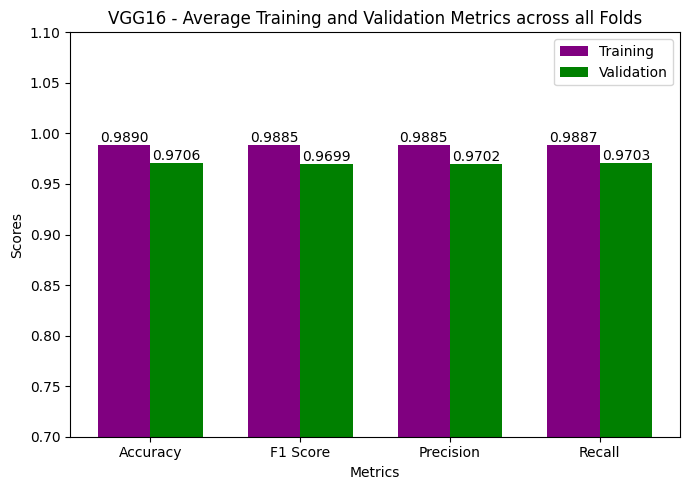

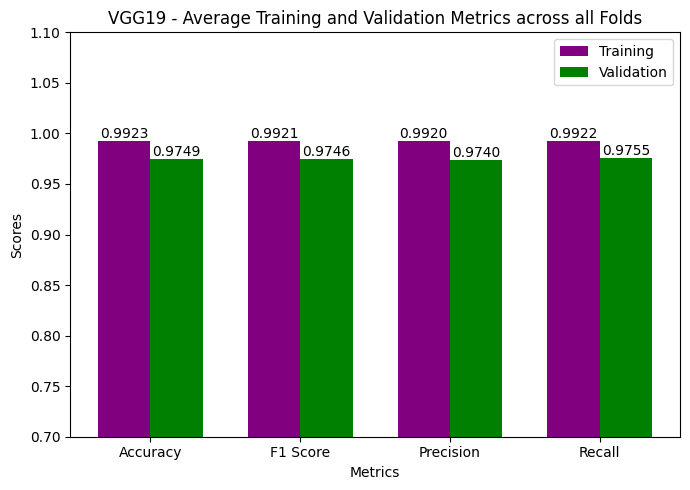

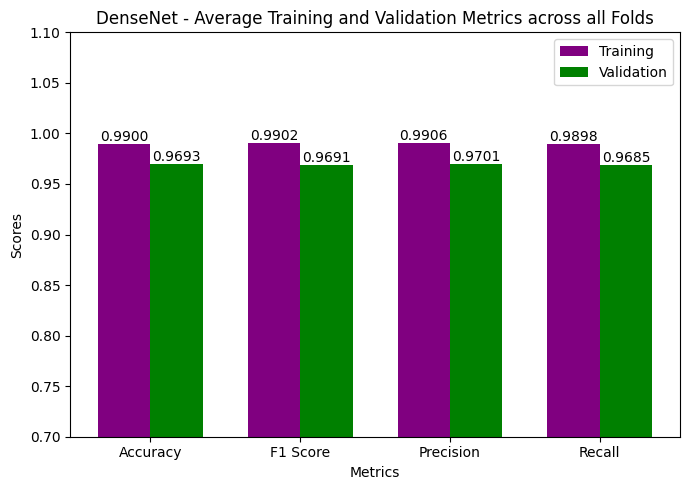

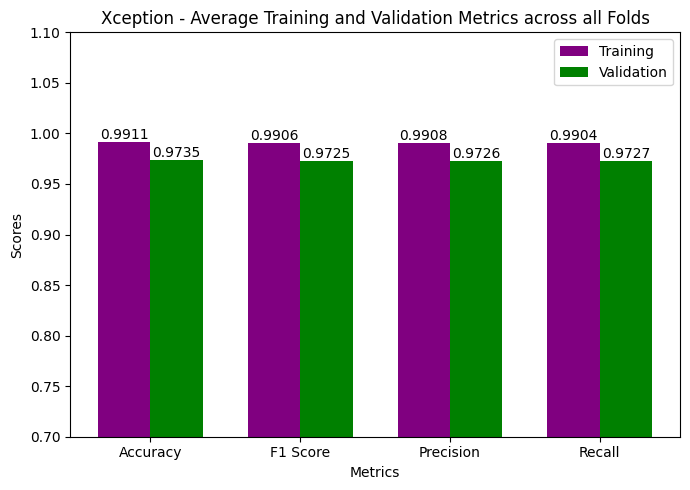

In [31]:
print()
print()
# Print the header
#print("\nAverage metrics across folds:")
display(HTML(f'<span style="color: black; background-color: lightgreen; font-size: 15px; font-weight: bold; padding: 5px;">Average metrics across folds:</span>'))
print()
print(f"{'Model Name':<15}{'Train_Acc':<15}{'Val_Acc':<15}{'Train_F1':<15}{'Val_F1':<15}{'Train_Precision':<20}{'Val_Precision':<15}{'Train_Recall':<15}{'Val_Recall':<15}")
print("-" * 135)  # Add a separator line for clarity


# Print average accuracy, precision, recall, and F1 score for each model
for model_name in models.keys():
    avg_train_accuracy = np.mean(fold_train_metrics[model_name])
    avg_val_accuracy = np.mean(fold_val_metrics[model_name])
    avg_train_precision = np.mean(fold_train_precision[model_name])
    avg_val_precision = np.mean(fold_val_precision[model_name])
    avg_train_recall = np.mean(fold_train_recall[model_name])
    avg_val_recall = np.mean(fold_val_recall[model_name])
    avg_train_f1 = np.mean(fold_train_f1[model_name])
    avg_val_f1 = np.mean(fold_val_f1[model_name])

    # Print the metrics for each model
    print(f"{model_name:<15}{avg_train_accuracy:<15.4f}{avg_val_accuracy:<15.4f}{avg_train_f1:<15.4f}{avg_val_f1:<15.4f}{avg_train_precision:<20.4f}{avg_val_precision:<15.4f}{avg_train_recall:<15.4f}{avg_val_recall:<15.4f}")

    """
    print(f"\n{model_name}:")
    # Print average metrics in two columns for training and validation
    print()
    print(f"{'Parameter':<35}{'Training':<15}{'Validation':<15}")
    print("-" * 55)  # Add a separator line for clarity

    print(f"{'Average Accuracy ('+model_name+'):':<35}{avg_train_accuracy:<15.4f}{avg_val_accuracy:.4f}")
    print(f"{'Average F1 Score ('+model_name+'):':<35}{avg_train_f1:<15.4f}{avg_val_f1:.4f}")
    print(f"{'Average Precision ('+model_name+'):':<35}{avg_train_precision:<15.4f}{avg_val_precision:.4f}")
    print(f"{'Average Recall ('+model_name+'):':<35}{avg_train_recall:<15.4f}{avg_val_recall:.4f}")
    print()
    """



#To plot the bar for the same
# Lists to store metrics for visualization
print()
print()
# Calculate average metrics across folds
#print("\nAverage metrics across folds: Bar Plots")
display(HTML(f'<span style="color: navy; background-color: violet; font-size: 15px; font-weight: bold; padding: 5px;">Average metrics across folds: Bar Plots:</span>'))
print()
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
model_names = ['VGG16', 'VGG19', 'DenseNet', 'Xception']

# Prepare lists to store metric values for plotting
train_metrics = {metric: [] for metric in metrics}
val_metrics = {metric: [] for metric in metrics}


for model_name in models.keys():
    # Store metrics for plotting

    # Dynamically calculate averages for the current model
    avg_train_accuracy = np.mean(fold_train_metrics[model_name])
    avg_val_accuracy = np.mean(fold_val_metrics[model_name])
    avg_train_f1 = np.mean(fold_train_f1[model_name])
    avg_val_f1 = np.mean(fold_val_f1[model_name])
    avg_train_precision = np.mean(fold_train_precision[model_name])
    avg_val_precision = np.mean(fold_val_precision[model_name])
    avg_train_recall = np.mean(fold_train_recall[model_name])
    avg_val_recall = np.mean(fold_val_recall[model_name])


    train_metrics['Accuracy'].append(avg_train_accuracy)
    val_metrics['Accuracy'].append(avg_val_accuracy)
    train_metrics['F1 Score'].append(avg_train_f1)
    val_metrics['F1 Score'].append(avg_val_f1)
    train_metrics['Precision'].append(avg_train_precision)
    val_metrics['Precision'].append(avg_val_precision)
    train_metrics['Recall'].append(avg_train_recall)
    val_metrics['Recall'].append(avg_val_recall)

# Bar plot for training and validation metrics for each model
# Prepare data for the bar plot
    metrics_values = [avg_train_accuracy, avg_train_f1, avg_train_precision, avg_train_recall]
    val_metrics_values = [avg_val_accuracy, avg_val_f1, avg_val_precision, avg_val_recall]

    # Create a bar plot for the current model
    fig, ax = plt.subplots(figsize=(7, 5))

    # Plot bars for training and validation metrics
    width = 0.35  # width of the bars
    x = np.arange(len(metrics))  # x locations for the groups

    bars_train = ax.bar(x - width/2, metrics_values, width, label='Training', color='purple')
    bars_val = ax.bar(x + width/2, val_metrics_values, width, label='Validation', color='green')

    # Add values on top of the bars
    for bar in bars_train:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='black')

    for bar in bars_val:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='black')

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'{model_name} - Average Training and Validation Metrics across all Folds')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0.7, 1.1)

    # Display the plot
    plt.tight_layout()
    plt.show()
    print()


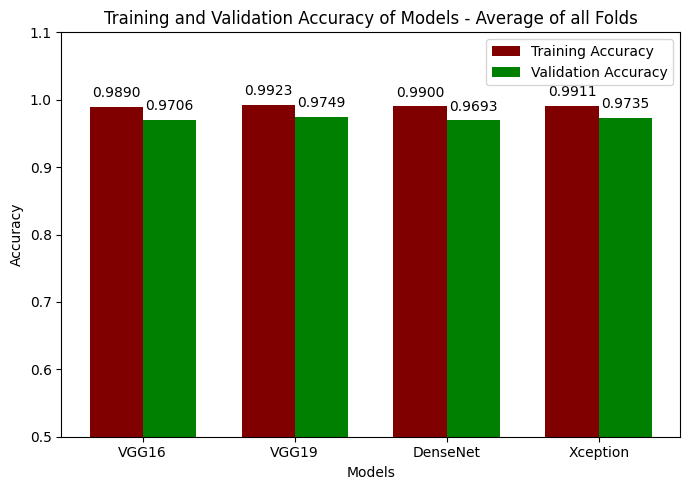

In [32]:
# Lists to store model names and corresponding accuracies for visualization
model_names = []
train_accuracies = []
val_accuracies = []

for model_name in models.keys():
    avg_train_accuracy = np.mean(fold_train_metrics[model_name])
    avg_val_accuracy = np.mean(fold_val_metrics[model_name])


    # Append to lists
    model_names.append(model_name)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)


# Bar plot for training and validation accuracies
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars
print()
fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='maroon')
bars2 = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy', color='green')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy of Models - Average of all Folds')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.set_ylim(0.5, 1.1)

# Add accuracy values on the bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [33]:
# Print average majority voting and sum rule accuracy
print()
average_majority_voting_accuracy = np.mean(fold_accuracies["MajorityVoting"])

average_majority_voting_precision = np.mean(fold_majority_voting_precision)
average_majority_voting_recall = np.mean(fold_majority_voting_recall)
average_majority_voting_f1 = np.mean(fold_majority_voting_f1)

average_sum_rule_accuracy = np.mean(fold_accuracies["SumRule"])
average_sum_rule_precision = np.mean(fold_sum_rule_precision)
average_sum_rule_recall = np.mean(fold_sum_rule_recall)
average_sum_rule_f1 = np.mean(fold_sum_rule_f1)



# Print average majority voting and sum rule metrics in two columns for training and validation
print()
#print('Average Validation metrics of Majority Voting and Sum rule across all folds: ')
display(HTML(f'<span style="color: navy; background-color: lime; font-size: 15px; font-weight: bold; padding: 5px;">Average Validation metrics of Majority Voting and Sum rule across all folds:</span>'))
print()
print(f"{'Test Parameter':<35}{'Majority Voting':<25}{'Sum Rule':<15}")
print("-" * 65)  # Separator line for clarity

# Print average majority voting metrics
print(f"{'Average Accuracy:':<35}{average_majority_voting_accuracy:<25.4f}{average_sum_rule_accuracy:.4f}")
print(f"{'Average F1 Score:':<35}{average_majority_voting_f1:<25.4f}{average_sum_rule_f1:.4f}")
print(f"{'Average Precision:':<35}{average_majority_voting_precision:<25.4f}{average_sum_rule_precision:.4f}")
print(f"{'Average Recall:':<35}{average_majority_voting_recall:<25.4f}{average_sum_rule_recall:.4f}")
print()


Test Parameter                     Majority Voting          Sum Rule       
-----------------------------------------------------------------
Average Accuracy:                  0.9837                   0.9869
Average F1 Score:                  0.9836                   0.9866
Average Precision:                 0.9833                   0.9865
Average Recall:                    0.9839                   0.9869



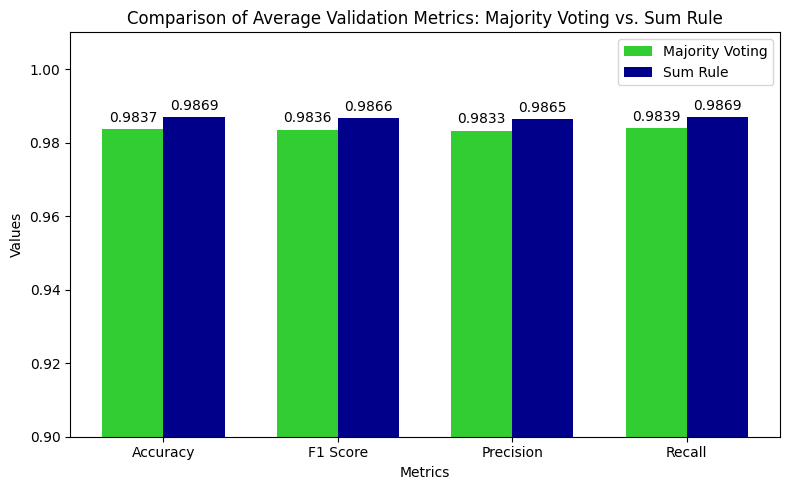

In [51]:
# Data for bar plot
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
majority_voting_values = [
    average_majority_voting_accuracy,
    average_majority_voting_f1,
    average_majority_voting_precision,
    average_majority_voting_recall,
]
sum_rule_values = [
    average_sum_rule_accuracy,
    average_sum_rule_f1,
    average_sum_rule_precision,
    average_sum_rule_recall,
]

# Bar positions
x = np.arange(len(metrics))  # Metrics as x-axis positions
width = 0.35  # Bar width

# Plotting the bar diagram
print()
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, majority_voting_values, width, label='Majority Voting', color='limegreen')
bars2 = ax.bar(x + width/2, sum_rule_values, width, label='Sum Rule', color='darkblue')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
plt.ylim(0.9, 1.01)
ax.set_title('Comparison of Average Validation Metrics: Majority Voting vs. Sum Rule')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for text
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()
print()

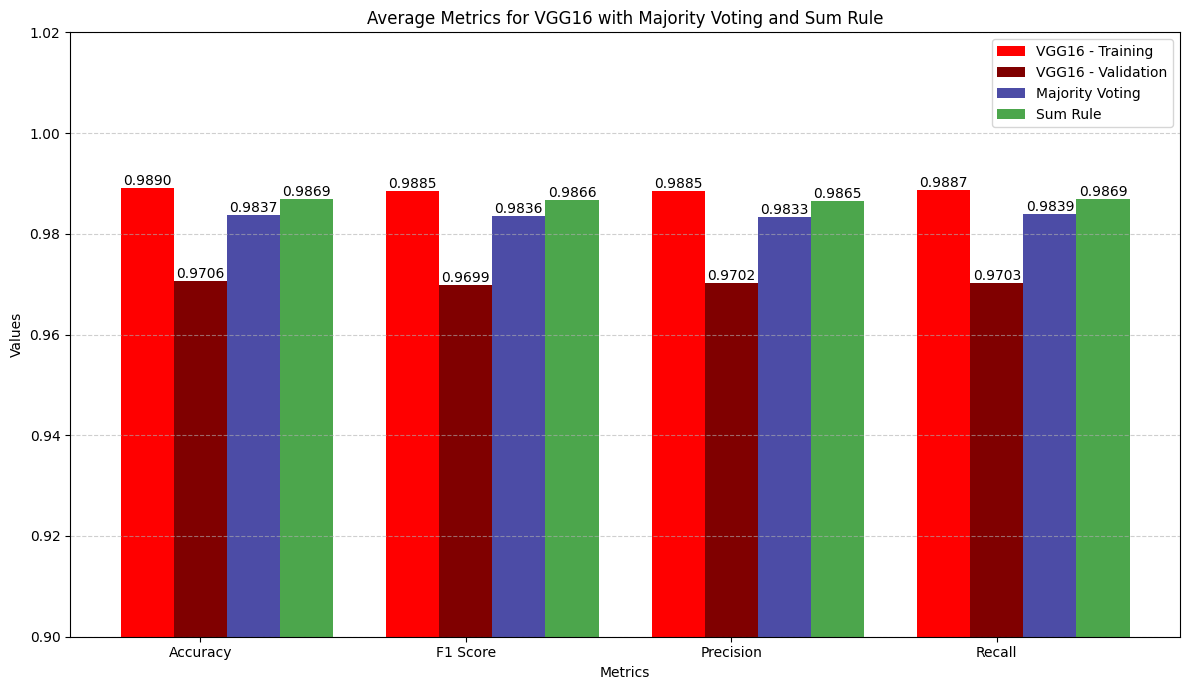

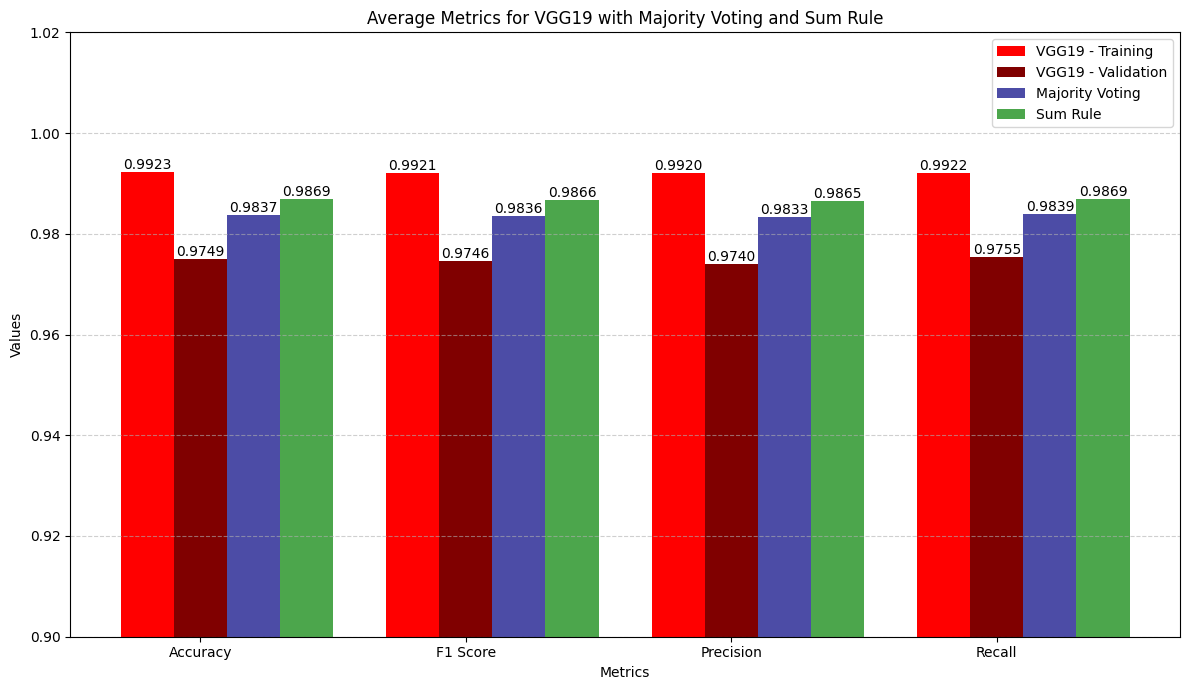

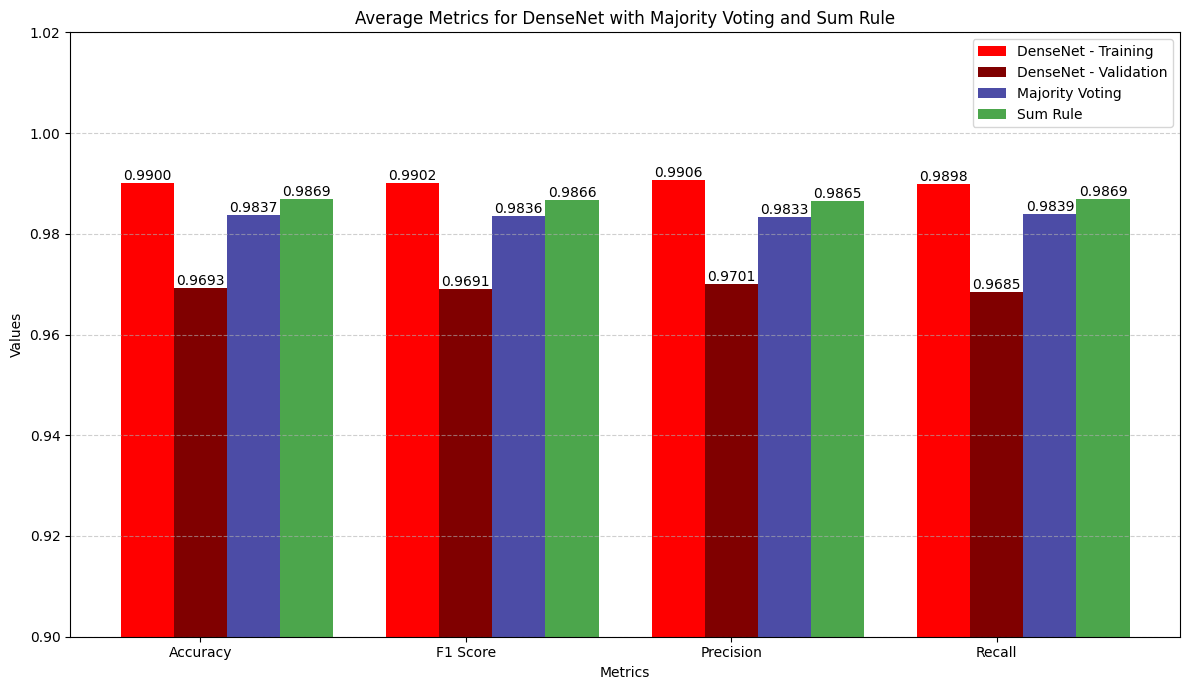

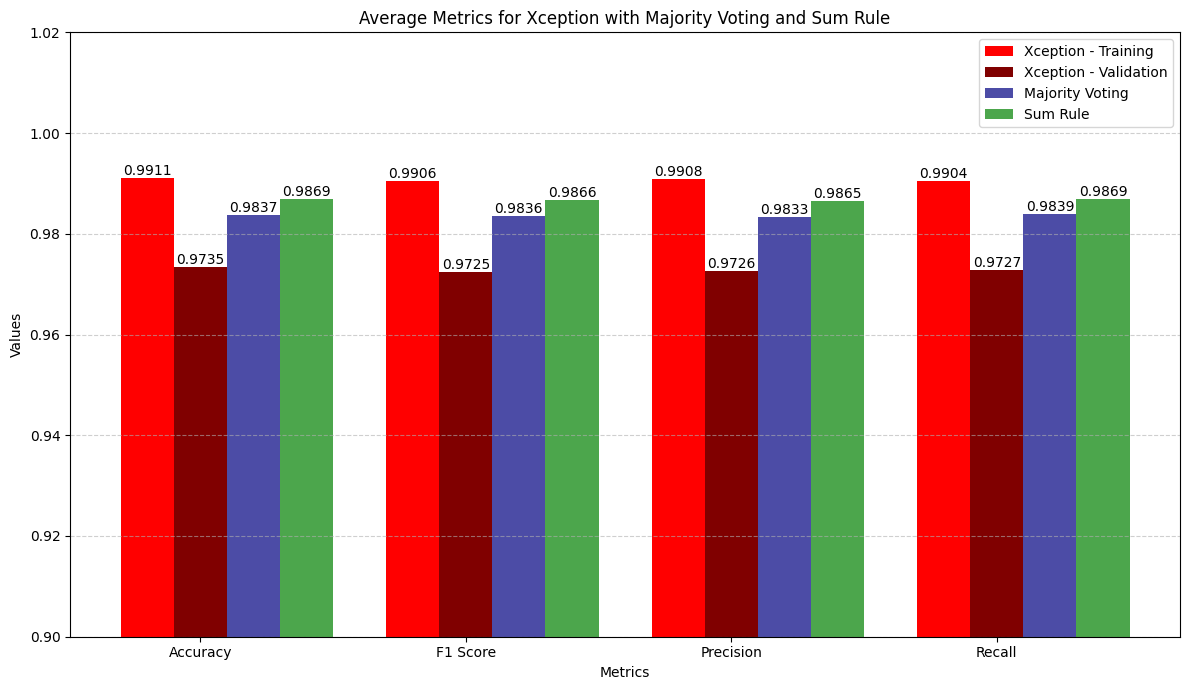

In [52]:
# Prepare data for the bar chart
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
train_metrics = {}
val_metrics = {}

# Add metrics for each model
for model_name in models.keys():
    train_metrics[model_name] = [
        np.mean(fold_train_metrics[model_name]),
        np.mean(fold_train_f1[model_name]),
        np.mean(fold_train_precision[model_name]),
        np.mean(fold_train_recall[model_name]),
    ]
    val_metrics[model_name] = [
        np.mean(fold_val_metrics[model_name]),
        np.mean(fold_val_f1[model_name]),
        np.mean(fold_val_precision[model_name]),
        np.mean(fold_val_recall[model_name]),
    ]

# Add Majority Voting and Sum Rule metrics for comparison
majority_voting_metrics = [
    average_majority_voting_accuracy,
    average_majority_voting_f1,
    average_majority_voting_precision,
    average_majority_voting_recall,
]

sum_rule_metrics = [
    average_sum_rule_accuracy,
    average_sum_rule_f1,
    average_sum_rule_precision,
    average_sum_rule_recall,
]
print()
# Plot bar chart for each model
for model_name in models.keys():
    x = np.arange(len(metrics))  # the label locations
    width = 0.2  # the width of the bars

    plt.figure(figsize=(12, 7))

    # Bars for the current model
    bars_train = plt.bar(x - width, train_metrics[model_name], width, label=f'{model_name} - Training', color='red')
    bars_val = plt.bar(x, val_metrics[model_name], width, label=f'{model_name} - Validation', color='maroon')

    # Bars for Majority Voting and Sum Rule
    bars_majority = plt.bar(x + width, majority_voting_metrics, width, label='Majority Voting', color='navy', alpha=0.7)
    bars_sum_rule = plt.bar(x + 2 * width, sum_rule_metrics, width, label='Sum Rule', color='green', alpha=0.7)

    # Add values on top of each bar
    for bar in bars_train:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    for bar in bars_val:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    for bar in bars_majority:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    for bar in bars_sum_rule:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Customize the chart
    plt.title(f"Average Metrics for {model_name} with Majority Voting and Sum Rule")
    plt.xlabel("Metrics")
    plt.ylabel("Values")
    plt.xticks(x, metrics)
    plt.ylim(0.9, 1.02)  # Set the y-axis limit for better visualization
    plt.legend(loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Show the plot
    plt.tight_layout()
    plt.show()
    print()